# Ejercicio Practico 5
## Series Temporales

El próximo ejercicio práctico, tratan sobre el tema de analisis de series temporales. Para ello, generaremos varios conjuntos de datos que contengas series temporales y que sirvan de ejemplo para ilustrar los conceptos de las series.

La primera parte del ejercicio abordará los conceptos básicos de series, su descomposión en componentes, la estacionariedad y su búsqueda, y por último los modelos de suavizado. En la segunda parte de la práctica se profundizará en las funciones de autocorrelación y los modelos autoregresivos, medias móviles y ARIMA.

### 1. Diseño de la serie temporal

En primer lugar vamos a importar las librerías de python que serán necesarias para realizar el analisis y a continuación crearemos una primera serie temporal que servirá de ejemplo para ilustrar los conceptos básicos más importantes.

In [2]:
# Importar las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import boxcox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

Diseñamos una serie temporal con 800 valores ordenados. Podríamos transformar el índice a fechas para darle más realismo a la serie temporal, pero no es algo muy relevante que vaya a tener impacto en el analisis puesto que son datos ficticios y por ello vamos dejarlos como índice númerico con un orden establecido.

La serie a crear será una serie NO estacionaria que presentará una tendencia lineal, una estacionalidad con amplitud creciente y una componente de ruido tambien con amplitud creciente.

In [2]:
# Configuración inicial
np.random.seed(42)
time = np.arange(0, 800)

# Construcción de Serie temporal
non_stationary_trend = 0.05 * time
non_stationary_amplitude = 1 + 0.01 * time
non_stationary_series = non_stationary_trend + non_stationary_amplitude * np.sin(2 * np.pi * time / 50) + np.random.normal(0, 0.5 + 0.01 * time, len(time))

# Crear un DataFrame
df = pd.DataFrame({'time': time, 'serie': non_stationary_series})

Mostramos la gráfica para ver la pinta que tiene la serie que hemos creado

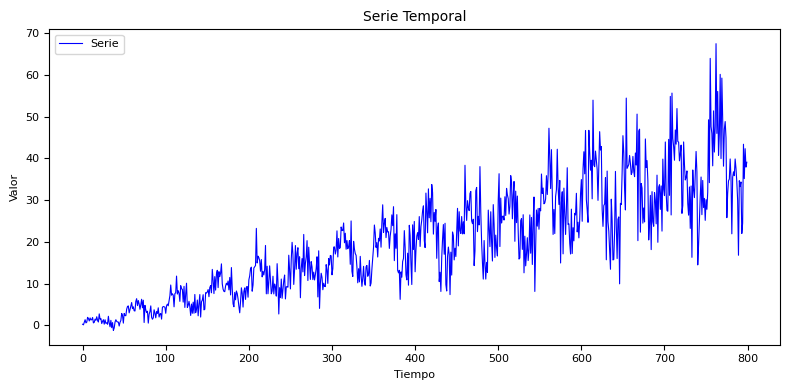

In [3]:
# Mostrar gráfica de la serie temporal
plt.figure(figsize=(8, 4))

# Opciones del gráfico
plt.plot(df['time'], df['serie'], label="Serie", color='blue', linewidth=0.8)
plt.title("Serie Temporal", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Echamos un primer vistazo a la forma que tiene la serie temporal y vemos que se trata de una serie cuyo valor va en aumento a lo largo del tiempo. Es decir que tiene una tendencia clara de largo plazo creciente. Parece tener además una componente estacional puesto que parece tener una especie de forma de onda que se repite en el tiempo. Por otro lado, tiene una componente de ruido que parece aleatorio y que acompaña a la serie a lo largo de toda la franja temporal. Incluso se puede intuir que dicha componente parece mayor cuanto más nos alejamos en el tiempo. El analisis de descomposición en componentes nos confirmará algunas de estas impresiones y arrojará algo más de luz sobre otras.

### 2. Analisis de componentes de la serie temporal ###

En este apartado vamos a ir descomponiendo e interpretando las componentes de una serie temporal: tendencia, estacionalidad y ruido. Empezamos analizando la componente de tendencia. Para ello vamos a preparar un proceso que calcule la tendencia mediante media movil de cierto tamaño de la ventana.

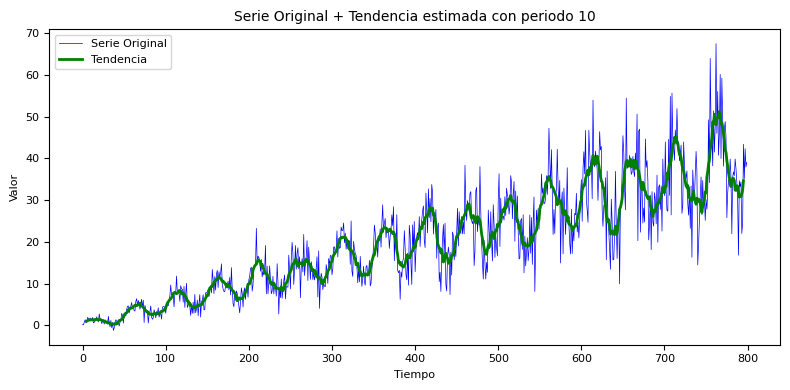

In [4]:
window_long = 10  # Longitud del período (por ejemplo, meses en un año)

# Suavizado para estimar la tendencia (media móvil de window_long puntos)
df["trend_estimated"] = df["serie"].rolling(window=window_long, center=True).mean()

# Mostrar grafica de tendencia
plt.figure(figsize=(8, 4))

# Serie Temporal más tendencia estimada
plt.plot(df['time'], df['serie'], label="Serie Original", color='blue', linewidth=0.5)
plt.plot(df['time'], df['trend_estimated'], label="Tendencia", color='green', linewidth=2)
plt.title("Serie Original + Tendencia estimada con periodo 10", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

En el ejemplo se ha estimado la tendencia con una ventana deslizante para la media movil de 10 puntos. La ventana tendría como punto central cada uno de los puntos sobre los que va calculando el suavizado. El suavizado se ve que se adapta bastante bien a la forma de onda de la gráfica. Basicamente lo que hace es eliminar la componente de ruido. Sin embargo, las oscilaciones periodicas las respeta. Esto es porque la ventana, al ser de un tamaño aparentemente pequeño, no es capaz de suavizarlas en el tiempo.

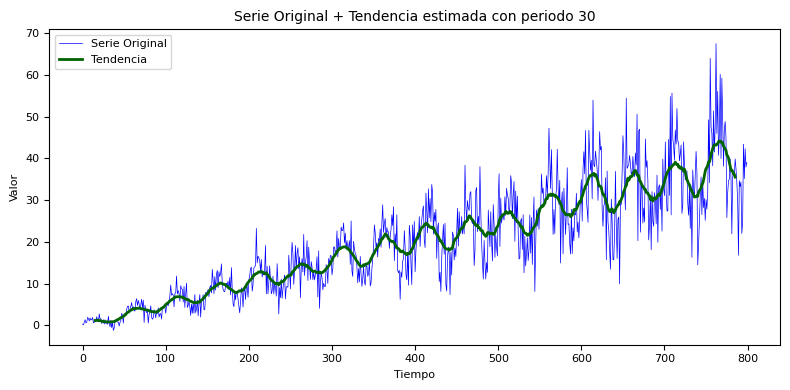

In [5]:
window_long = 30  # Longitud del período (por ejemplo, meses en un año)

# Suavizado para estimar la tendencia (media móvil de 12 puntos)
df["trend_estimated"] = df["serie"].rolling(window=window_long, center=True).mean()

# Mostrar grafica de tendencia
plt.figure(figsize=(8, 4))

# Serie Temporal más tendencia estimada
plt.plot(df['time'], df['serie'], label="Serie Original", color='blue', linewidth=0.5)
plt.plot(df['time'], df['trend_estimated'], label="Tendencia", color='darkgreen', linewidth=2)
plt.title("Serie Original + Tendencia estimada con periodo 30", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Ampliamos el tamaño de la ventana de la media movil y al hacerlo vemos que se reduce la amplitud de las oscilaciones de la serie suavizada, dejandonos una tendencia un poco más suavizada y con oscilaciones un poco más sutiles que en la anterior. A continuación vamos a aumentar a 75 la ventana para ver como se comporta conforme aumentamos esta ventana.

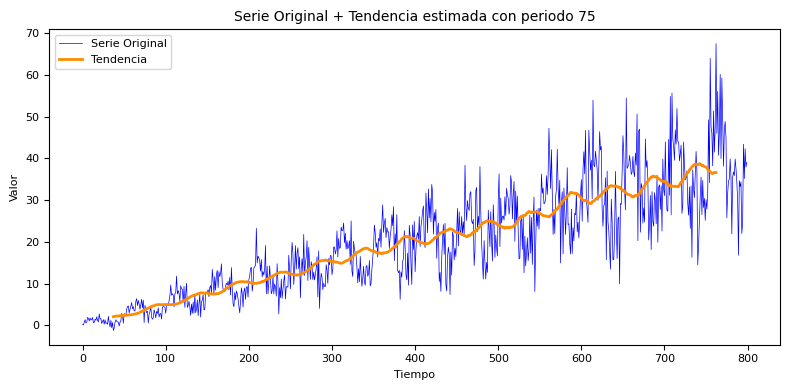

In [6]:
window_long = 75  # Longitud del período (por ejemplo, meses en un año)

# Suavizado para estimar la tendencia (media móvil de 12 puntos)
df["trend_estimated"] = df["serie"].rolling(window=window_long, center=True).mean()

# Mostrar grafica de tendencia
plt.figure(figsize=(8, 4))

# Serie Temporal más tendencia estimada
plt.plot(df['time'], df['serie'], label="Serie Original", color='blue', linewidth=0.5)
plt.plot(df['time'], df['trend_estimated'], label="Tendencia", color='darkorange', linewidth=2)
plt.title("Serie Original + Tendencia estimada con periodo 75", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Se ve claramente que siguen minizandose las oscilaciones. Al aumentar más la ventana, la cantidad de información que promediamos en cada punto es mayor y por tanto se va suavizando y perdiendo cada vez más, no solo la componente de ruido, si no también la oscilación estacional. Vamos a hacer una prueba más con una ventana de tamaño 50. La lógica según hemos visto en los distintos ejemplos apunta a que si empleamos una ventana de tamaño 50 que se encuentra entre 30 y 75, debería ser un suavizado que atenúe más la oscilación que el suavizado con ventana de 30 pero inferior a este último de tamaño 75.

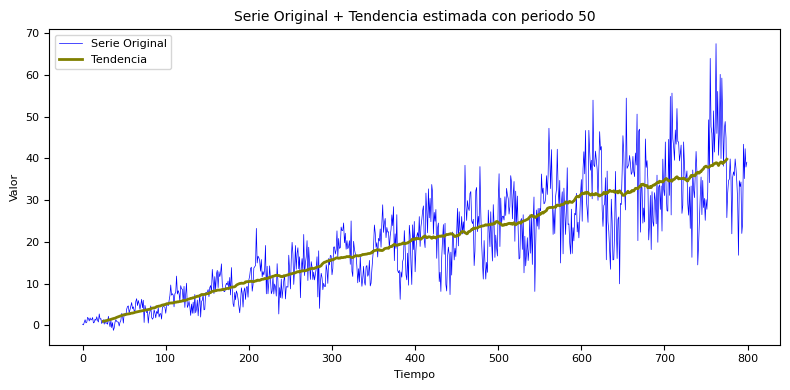

In [7]:
window_long = 50  # Longitud del período (por ejemplo, meses en un año)

# Suavizado para estimar la tendencia (media móvil de 12 puntos)
df["trend_estimated"] = df["serie"].rolling(window=window_long, center=True).mean()

# Mostrar grafica de tendencia
plt.figure(figsize=(8, 4))

# Serie Temporal más tendencia estimada
plt.plot(df['time'], df['serie'], label="Serie Original", color='blue', linewidth=0.5)
plt.plot(df['time'], df['trend_estimated'], label="Tendencia", color='olive', linewidth=2)
plt.title("Serie Original + Tendencia estimada con periodo 50", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Creíamos que iba a ser menor el suavizado que el de la ventana de 75 y algo mayor que el de la ventana de 30. Sin embargo nos encontramos con el mayor de los suavizados vistos hasta ahora. Es más, está tan suavizada que ya no se aprecian las oscilaciones estacionales. Es prácticamente una línea recta, es decir, tendencia pura. Hay alguna irregularidad en la linea (como si la hubieramos pintado a mano alzada) y esto es por la componente de ruido, que al promediar en una venta de 50 a veces es un poquito mayor el resultado y otras un poquito menor. Como depende del ruido y éste es aleatorio, no se trata de una línea pura recta si no una recta ruidosa.

La razón por la que se ha perdido por completo la componente estacional, es porque estamos promediando en una ventana equivalente al periodo de la estacionalidad. Es decir, la estacionalidad se repite cada 50 puntos y esta es la razón por la que desaparece. En general, esta componente desaparece cuando promediamos en un periodo. Es cierto que puede dejar un nivel equivalente al promedio de la serie en un periodo, pero si la amplitud de la oscilación no varía con el tiempo, entonces debería ser constante y por tanto tendríamos una linea recta siempre que indica la tendencia pura de la serie original más una pequeña componente de nivel de la oscilación.

Pasamos ahora a extraer de la serie original esta tendencia que acabamos de calcular con la ventana deslizante de tamaño igual al periodo. Al hacerlo nos queda como resultado todo lo que no sea tendencia en la serie. Es decir, las componentes de estacionalidad y ruido.

In [8]:
# Extraer componente estacional + ruido
df['seasonality_noise'] = df['serie'] - df['trend_estimated']

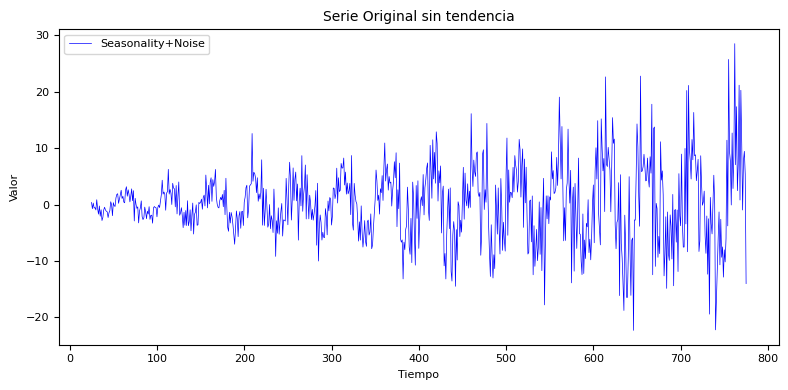

In [9]:
# Mostrar grafica
plt.figure(figsize=(8, 4))

# Serie original sin tendencia estimada
plt.plot(df['time'], df['seasonality_noise'], label="Seasonality+Noise", color='blue', linewidth=0.5)
plt.title("Serie Original sin tendencia", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

En este caso la gráfica muestra lo que queda sin la tendencia y se puede ver claramente que ahora nuestra serie no aumenta su nivel con tendencia creciente si no que ahora tenemos una serie que va oscilando siempre en torno al 0. Es cierto que el tamaño de la oscilación va en aumento y la propia oscilación continúa aún presente.

El siguiente caso es extraer la componente estacional. Para ello vamos a promediar para cada posición dentro del periodo (1 a 50), todos los valores de todos los puntos que están situados en el mismo punto del periodo. Esto nos va a permitir obtener la componente estacional.

In [10]:
window_long = 50  # Longitud del período

# Aislar estacionalidad promediando por periodo (50)
df["period"] = df["time"] % window_long
seasonality_avg = df.groupby("period")["seasonality_noise"].mean()
df["seasonality_estimated"] = df["period"].map(seasonality_avg)

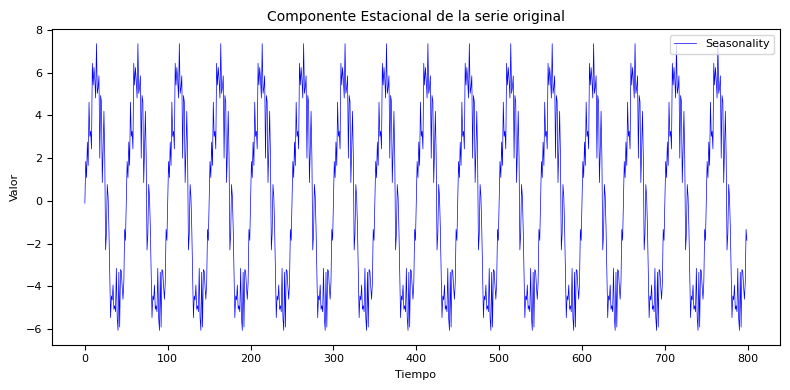

In [11]:
# Mostrar grafica
plt.figure(figsize=(8, 4))

# Componente estacional
plt.plot(df['time'], df['seasonality_estimated'], label="Seasonality", color='blue', linewidth=0.5)
plt.title("Componente Estacional de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Se ha estimado la oscilación de un periodo y se ha replicado tantas veces como periodos tiene la serie. Eso es lo que se muestra en la gráfica anterior. Se puede ver que la forma que tiene la estacionalidad de esta serie es igual que la forma de una función seno. La forma podría ser completamente distinta y repetirse a lo largo de toda la serie. En este caso, al haberse construido a partir de la función seno, este es el resultado de la componente estacional. Si se hubiera empleado otro tamaño para la ventana deslizante de la tendencia, que no fuera el periodo, al extraer esta componente se capturaría una forma diferente a la que se ve en la gráfica. En mayor o menor medida dependiendo de la función y de la desviación respecto del periodo o de cualquier multiplo del periodo. Al hacerlo todo coherente con el periodo de la estacionalidad, la forma que extraemos es exactamente la de la oscilación estacional (más el ruido).

Vamos ahora a sacar la componente de ruido final o el residuo tras haber extraido el resto de componentes. Para ello le restamos la componente estacional que hemos calculado y replicado en todos sus periodos.

In [12]:
# Extraer ruido como residuo
df["noise_estimated_add"] = df["seasonality_noise"] - df["seasonality_estimated"]

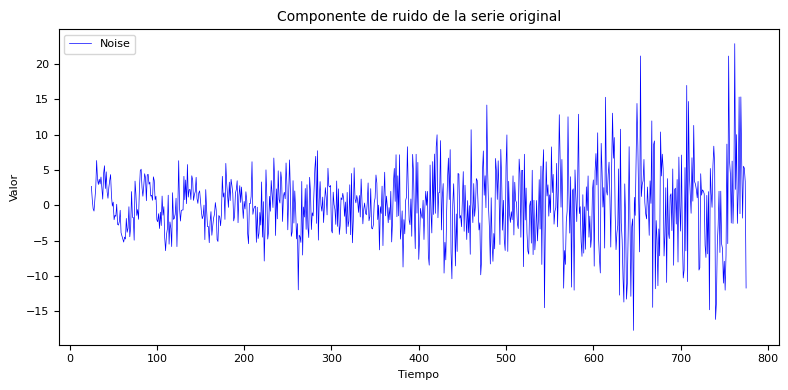

In [13]:
# Mostrar grafica
plt.figure(figsize=(8, 4))

# Componente de ruido
plt.plot(df['time'], df['noise_estimated_add'], label="Noise", color='blue', linewidth=0.5)
plt.title("Componente de ruido de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Se puede ver que efectivamente la serie ya no tiene prácticamente oscilación ni tendencia y todo lo que le queda es el ruido. Aun así, en este caso aun podemos ver algun resquicio de oscilación al principio de la serie y también vemos que aunque no tenga tendencia, si que parece tener una amplitud creciente.

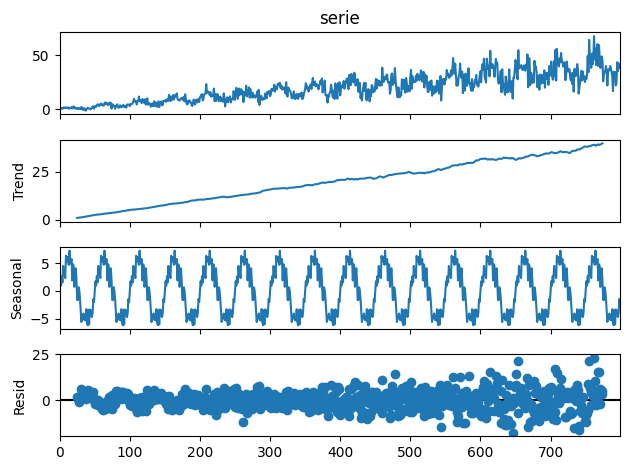

In [14]:
# Realizamos la descomposición de la serie en sus componentes
df_decomposed = seasonal_decompose(df['serie'], model='additive', period=50)  # Ajusta el período según corresponda (diario, anual, etc.)

# Graficamos la descomposición
df_decomposed.plot()
plt.show()

El hecho de que la componente residual aun tenga resquicios de estacionalidad y amplitudes crecientes puede estar relacionado con que hayamos aplicado un modelo aditivo para descomponer la serie en lugar de un modelo multiplicativo que recoge este tipo de particularidades. Para ello lo que vamos a realizar es de nuevo el proceso de descomposición pero esta vez mediante el modelo multiplicativo, para ver si conseguimos estabilizar los residuos como una serie completamente estacionaria y sin estacionalidad.

Comenzamos eliminando de la serie la tendencia. Para ello dividimos la serie entre la tendencia. Le hemos sumado 1 a la serie para evitar que haya valores negativos ya que luego al descomponer mediante el metodo seasonal_decompose, suele dar problemas.

In [15]:
# Extraer componente estacional + ruido
df['seasonality_noise'] = (df['serie']+1) / df['trend_estimated']

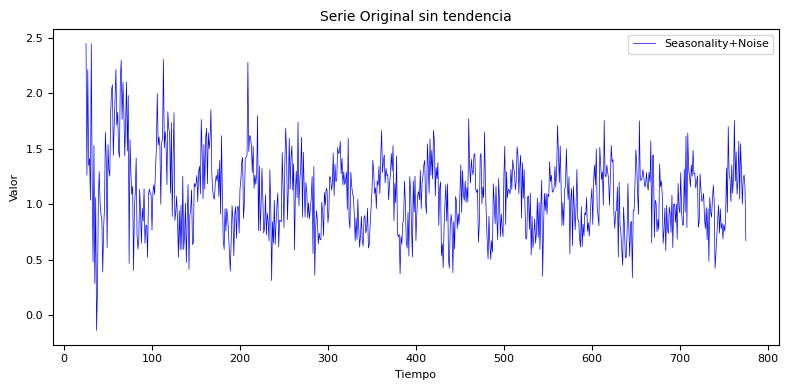

In [16]:
# Mostrar grafica
plt.figure(figsize=(8, 4))

# Serie original sin tendencia
plt.plot(df['time'], df['seasonality_noise'], label="Seasonality+Noise", color='blue', linewidth=0.5)
plt.title("Serie Original sin tendencia", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

El gráfico muestra la serie sin tendencia. Como se puede ver ahora tenemos una media estable en torno al valor 1 (porque le hemos sumado 1 en el paso anterior) y no muestra tendencia alguna. Solo contiene la parte estacional y el ruido.

Calculamos la componente estacional para luego quitarsela a la componente estacional+ruido que acabamos de obtener. De nuevo la estimamos promediando los periodos de la serie.

In [17]:
window_long = 50  # Longitud del período

# Aislar estacionalidad promediando por periodo (50)
df["period"] = df["time"] % window_long
seasonality_avg = df.groupby("period")["seasonality_noise"].mean()
df["seasonality_estimated"] = df["period"].map(seasonality_avg)

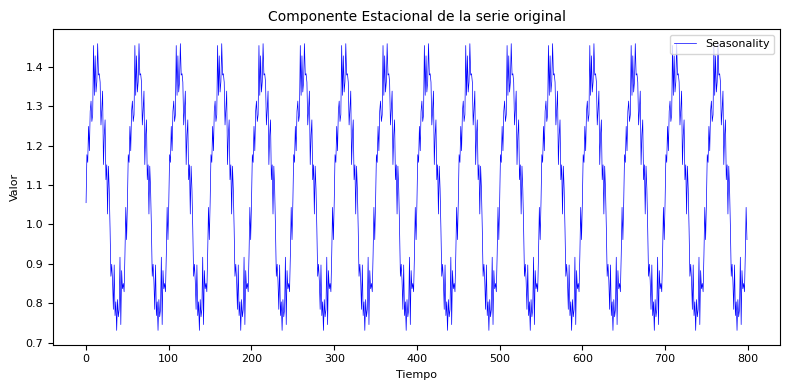

In [18]:
# Mostrar grafica
plt.figure(figsize=(8, 4))

# Componente estacional
plt.plot(df['time'], df['seasonality_estimated'], label="Seasonality", color='blue', linewidth=0.5)
plt.title("Componente Estacional de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Volvemos a tener una componente estacional en la que se ha calculado la forma de un periodo y que luego se ha replicado en tantos periodos como tiene nuestra serie. Ahora pasamos a extraer esta componente de la serie de estacionalidad+ruido que teniamos. En esta ocasión la dividimos en lugar de restarla por ser modelo multiplicativo.

In [19]:
# Extraer ruido como residuo
df["noise_estimated_mult"] = df["seasonality_noise"] / df["seasonality_estimated"]

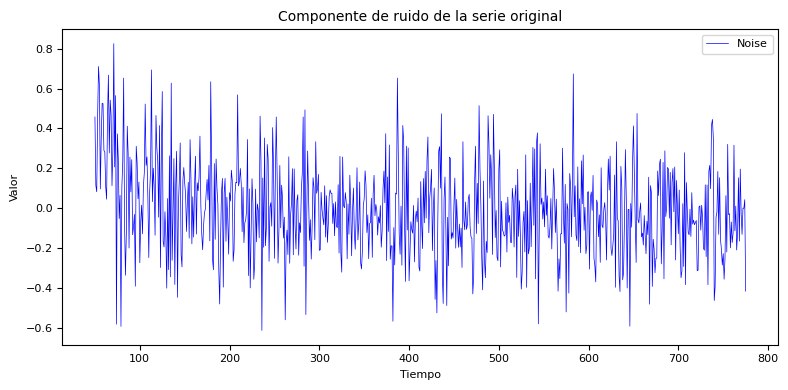

In [20]:
# Mostrar grafica
plt.figure(figsize=(8, 4))

# Componente de ruido
plt.plot(df['time'].iloc[50:], df['noise_estimated_mult'].iloc[50:]-1, label="Noise", color='blue', linewidth=0.5)
plt.title("Componente de ruido de la serie original", fontsize=10)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valor", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

Lo que obtenemos en la gráfica es la componente puramente de ruido. Aquí ya no tenemos tendencia ni estacionalidad. La gráfica la hemos pintado sin los primeros 50 puntos dado que al no disponer de valores de la serie anteriores, los calculos y promedios y suavizados en esos primeros puntos de la serie, no son muy buenos y por eso parece que tenemos nivel más alto.

A diferencia del modelo aditivo, ahora no tenemos una componente de ruido que aumenta su varianza a lo largo del tiempo. Este efecto lo hemos reducido y mitigado al emplear el modelo multiplicativo que precisamente tiene como misión eliminar esta parte. Tenemos por tanto una serie estacionaria sin estacionalidad.

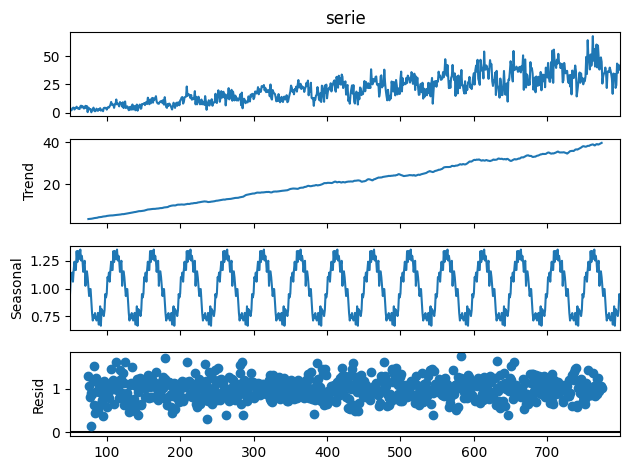

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizamos la descomposición de la serie en sus componentes
df_decomposed = seasonal_decompose(df['serie'].iloc[50:], model='multiplicative', period=50)  # Ajusta el período según corresponda (diario, anual, etc.)

# Graficamos la descomposición
df_decomposed.plot()
plt.show()

El modelo multiplicativo en la función seasonal_decompose, se ha de indicar en el parametro model y muestra los mismos resultados que con la descomposición manual que hemos hecho.


### 3. Analisis de estacionariedad ###

Ahora vamos a aplicar el test de Dickey Fuller aumentado para validar desde un punto de vista estadístico, la estacionariedad de la serie. Primero lo aplicamos a la serie original y luego se lo aplicamos al residuo de la serie con el modelo aditivo y luego el multiplicativo.

In [22]:
# Analizar mediante el test de Dickey-Fuller la estacionariedad serie original
adf_test = adfuller(df['serie']) 
print(f'Estadístico ADF: {adf_test[0]}')
print(f'P-valor: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("La serie es ahora estacionaria")
else:
    print("La serie aún no es estacionaria")

Estadístico ADF: -2.1180858801093954
P-valor: 0.23730463818890296
La serie aún no es estacionaria


El modelo original, dado que la serie presenta tendencia, estacionariedad e incluso variación en el tiempo de la amplitud de la estacionalidad y del ruido, es 100% normal que nos salga que no es estacionaria. El p-valor está por encima de 0.05 y por ello no podemos rechazar la hipotesis nula.

In [23]:
# Analizar mediante el test de Dickey-Fuller la estacionariedad residuo aditivo
adf_test = adfuller(df['noise_estimated_add'].dropna())  # Eliminar valores NaN
print(f'Estadístico ADF: {adf_test[0]}')
print(f'P-valor: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("La serie es ahora estacionaria")
else:
    print("La serie aún no es estacionaria")

Estadístico ADF: -8.59039343184459
P-valor: 7.31281004154733e-14
La serie es ahora estacionaria


In [24]:
# Analizar mediante el test de Dickey-Fuller la estacionariedad residuo multiplicativo
adf_test = adfuller(df['noise_estimated_mult'].dropna())  # Eliminar valores NaN
print(f'Estadístico ADF: {adf_test[0]}')
print(f'P-valor: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("La serie es ahora estacionaria")
else:
    print("La serie aún no es estacionaria")

Estadístico ADF: -9.495714004168205
P-valor: 3.553651587687219e-16
La serie es ahora estacionaria


Para los test de Dickey Fuller de los residuos por ambos modelos, se ve que ambos son series estacionarias desde un punto de vista estadístico. Sabemos que la varianza que tiene el residuo del modelo aditivo no es constante y por tanto no es 100% estacionaria, pero el test debe estar capturando como muy poquita la variación en el tiempo de esta varianza y por ello es por lo que determina que prácticamente lo es. Siendo más rigurosos nos iriamos al modelo multiplicativo que ademas su p-valor es todavía mas bajito (2 ordenes de mgnitud) pero podríamos utilizar el aditivo ya que no parece que se separe mucho de la estacionariedad. Curioso que al ojo humano sea tan sencillo ver que no es estacionaria y luego estadisticamente, se determine que sí que lo sea en lineas generales.

Ahora vamos a mostrar las gráficas de la función de autocorrelación para verificar visualmente la estacionariedad de la serie orginal y las dos residuales de ambos tipos de modelo.

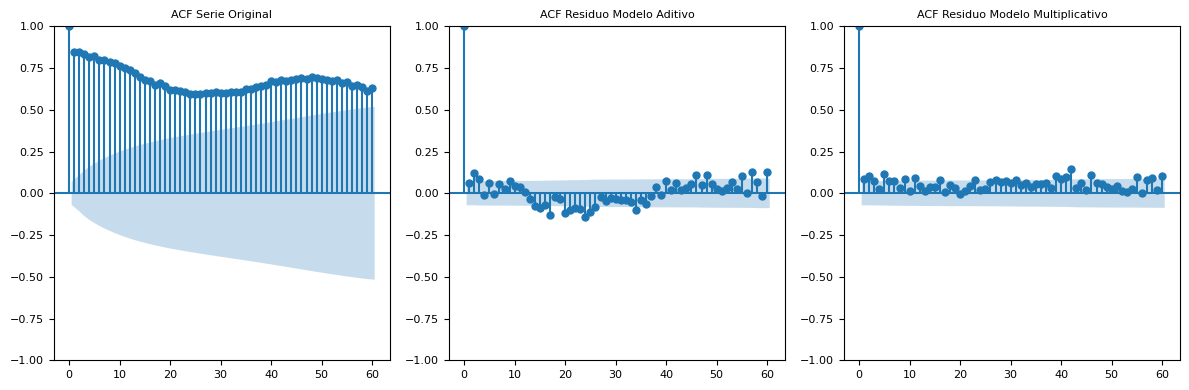

In [25]:
# Graficar ACF Serie original
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plot_acf(df['serie'].dropna(), lags=60, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Serie Original', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Graficar ACF Residuo Aditivo
plt.subplot(1, 3, 2)
plot_acf(df['noise_estimated_add'].dropna(), lags=60, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Residuo Modelo Aditivo', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Graficar ACF Residuo Multiplicativo
plt.subplot(1, 3, 3)
plot_acf(df['noise_estimated_mult'].dropna(), lags=60, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Residuo Modelo Multiplicativo', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Se ve claramente que la ACF de la serie original no es estacionaria puesto que todos sus retardos tienen valores de autocorrelación significativa con una caida muy leve en el tiempo. Toda la serie está correlada. Es normal puesto que tiene una tendencia clara y marcada así como una amplitud creciente en el tiempo de la componente estacional y del ruido.

Por otro lado las ACF de los residuos, especialmente la del modelo multiplicativo, se ve que tiene desde el primer valor una caida inclreible hacía valores cercanos a cero, por lo que se confirma la estacionariedad de la serie en este sentido.

Ahora vamos a trabajar la serie paso a paso convirtiendola en estacionaria desde la serie original. Dado que la serie original presenta variación de la amplitud en el tiempo, vamos a aplicarle una transformación de tipo boxcox para tratar de eliminar esa varianza creciente dejandola constante. Después le vamos a quitar la tendencia aplicando una diferenciación. Basicamente consiste en a cada valor, restarle el anterior. Esto elimina la tendencia cuando es lineal.

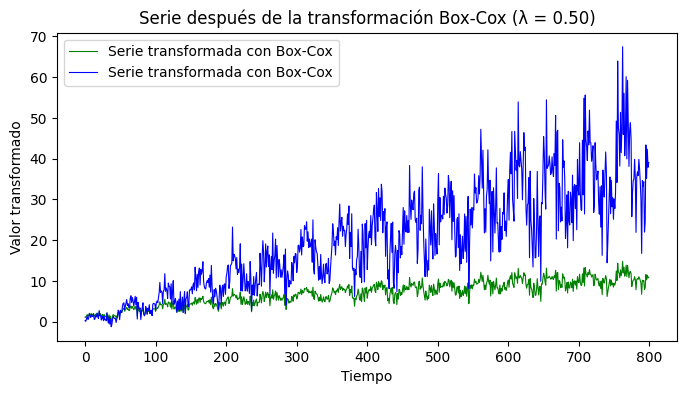

In [26]:
# Transformación de Box-Cox para estabilizar la varianza
df['serie_positiva'] = df['serie'] - np.min(df['serie']) + 1  # Ajuste para valores positivos
df['serie_boxcox'], lambda_bc = boxcox(df['serie_positiva'])  # Transformación Box-Cox

plt.figure(figsize=(8, 4))
plt.plot(df['time'], df['serie_boxcox'], label="Serie transformada con Box-Cox", color="green", linewidth=0.8)
plt.plot(df['time'], df['serie'], label="Serie transformada con Box-Cox", color="blue", linewidth=0.8)
plt.title(f"Serie después de la transformación Box-Cox (λ = {lambda_bc:.2f})")
plt.xlabel("Tiempo")
plt.ylabel("Valor transformado")
plt.legend()
plt.show()

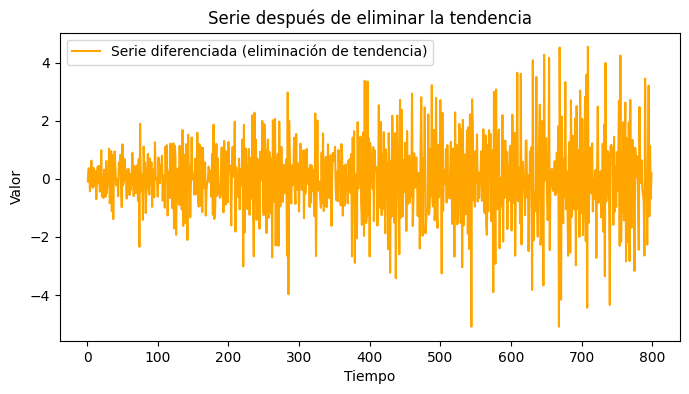

In [27]:
# Diferenciación para eliminar la tendencia
data_diff = np.diff(df['serie_boxcox'], n=1)
df['serie_boxcox_diff'] = np.concatenate(([np.nan], data_diff))

plt.figure(figsize=(8, 4))
plt.plot(df['time'], df['serie_boxcox_diff'], label="Serie diferenciada (eliminación de tendencia)", color="orange")
plt.title("Serie después de eliminar la tendencia")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()

Tras haber transformado la serie y haberla diferenciado para quitar tendencia, vemos que algo se ha reducido el aumento creciente de la varianza pero no del todo. Sigue mostrando una amplitud creciente. Vamos a probar con otra transformación, aplicaremos el logaritmo en vez de la boxcox.

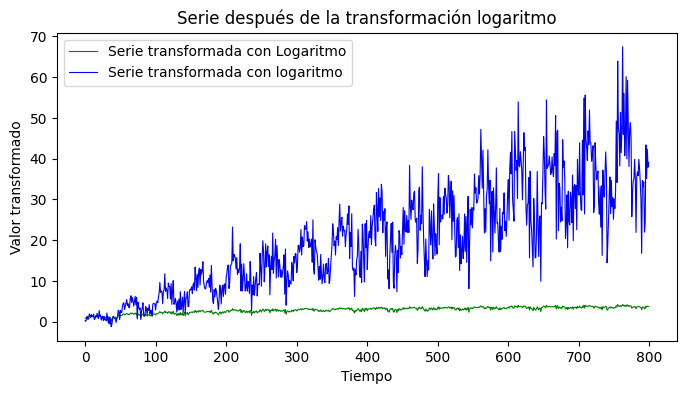

In [28]:
# Transformación logaritmica
df['serie_log'] = np.log(df['serie_positiva'])

plt.figure(figsize=(8, 4))
plt.plot(df['time'], df['serie_log'], label="Serie transformada con Logaritmo", color="green", linewidth=0.8)
plt.plot(df['time'], df['serie'], label="Serie transformada con logaritmo", color="blue", linewidth=0.8)
plt.title("Serie después de la transformación logaritmo")
plt.xlabel("Tiempo")
plt.ylabel("Valor transformado")
plt.legend()
plt.show()

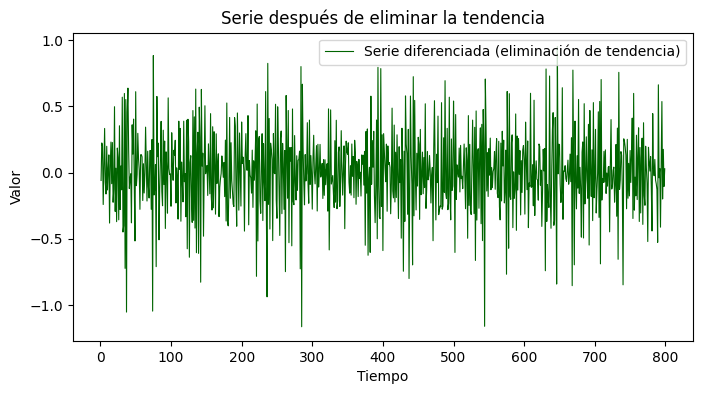

In [29]:
# Diferenciación para eliminar la tendencia
data_diff = np.diff(df['serie_log'], n=1)
df['serie_log_diff'] = np.concatenate(([np.nan], data_diff))

plt.figure(figsize=(8, 4))
plt.plot(df['time'], df['serie_log_diff'], label="Serie diferenciada (eliminación de tendencia)", color="darkgreen", linewidth=0.8)
plt.title("Serie después de eliminar la tendencia")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()

En este caso, la transformación parece mucho más apropiada y efectiva. La serie, tras haberla transformado y eliminado la tendencia, no muestra signos de varianza creciente. Parece una serie estacionaria a todos los efectos con media 0 y varianza constante. Para terminar, vamos a quitar también la estacionalidad. Para ello le vamos a restar a cada punto, su valor retardado tantos periodos como sea el periodo estacional (50 en este caso). Esto eliminará de la serie la componente estacional.

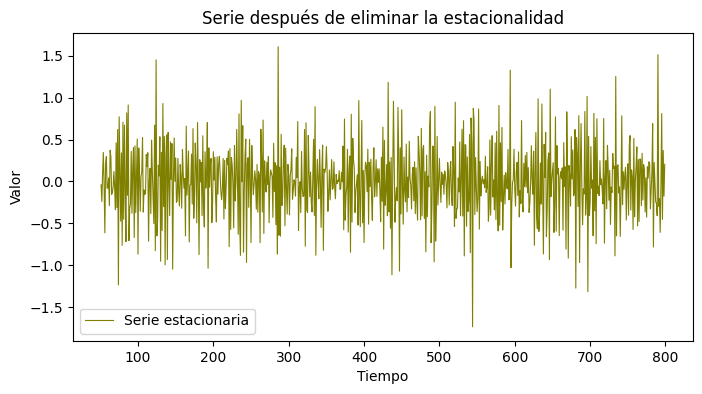

In [30]:
# Diferenciación estacional para eliminar la estacionalidad
seasonal_lag = window_long
data_diff_seasonal = data_diff[seasonal_lag:] - data_diff[:-seasonal_lag]

time_seasonal = time[seasonal_lag + 1:]

plt.figure(figsize=(8, 4))
plt.plot(time_seasonal, data_diff_seasonal, label="Serie estacionaria", color="olive", linewidth=0.8)
plt.title("Serie después de eliminar la estacionalidad")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()

Como resultado tenemos una serie estacionaria y sin estacionalidad a partir de la serie original. Es la misma idea que hemos seguido cuando hemos hecho la descomposición de la serie en sus distintas componentes. Aquí la diferencia es que la tendencia y la estacionalidad las hemos eliminado diferenciando en lugar de estimarlas y luego restarlas (modelo aditivo) o dividirlas (multiplicativo) de la serie original.

### 4. Suavizado de series temporales ###

En este apartado se va a estudiar más en detalle lo relativo al suavizado de series temporales. El suavizado tiene 3 principales objetivos: uno la eliminación del ruido, otro sería la estimación de la componente de tendencia de una serie y por último, la predicción de valores futuros. El primero es el más habitual y más típico ya que, como su nombre indica, suavizamos los cambios rápidos que genera aleatoriamente el ruido sobre nuestra serie. De esta forma nos abstraemos de ese ruido y podemos visualizar las otras componentes que realmente son las que mayor cantidad de información aportan sobre la serie temporal. 

Por otro lado, el segundo objetivo también es muy empleado ya que la estimacón de la tendencia es muy importante para analizar y entender la serie temporal y también para trabajar con ella por ejemplo para obtener otras componetes, estacionarizar la serie o incluso detectar patrones.

La predicción, dado que no es su fuerte, ya que predecir con un modelo de suavizado no es lo más preciso del mundo, no suele llevarse a cabo. Hay otros medios mejores como los modelos ARIMA o SARIMA que tienen mejores resultados.

Empezamos con la técnica de suavizado simple con un parametro alfa de nivel de suavizado configurado en 0.2.

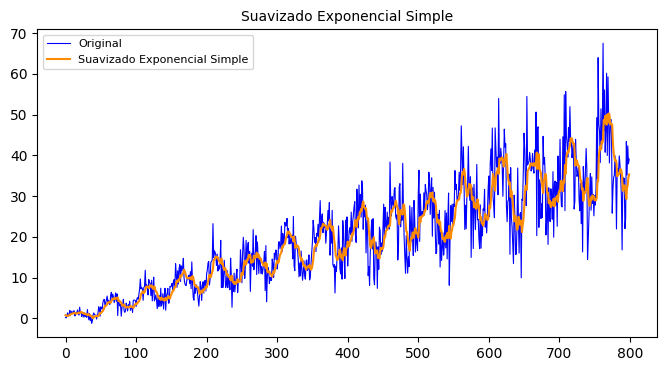

In [31]:
# Aplicar suavizado exponencial simple
model_suavizado1 = ExponentialSmoothing(df['serie'], trend=None, seasonal=None, damped_trend=False, seasonal_periods=None)
model_suavizado1 = model_suavizado1.fit(smoothing_level=0.2)  # Ajusta el smoothing_level según sea necesario

# Predicción
predictions1 = model_suavizado1.fittedvalues

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(df['serie'], label='Original', color='blue', linewidth=0.8)
plt.plot(predictions1, label='Suavizado Exponencial Simple', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Simple', fontsize=10)
plt.legend(fontsize=8)
plt.show()

Como se puede ver, se suaviza bastante el ruido presente a lo largo de la serie. Se mantiene la tendencia y la forma estacional de la serie puesto que solo se está suavizando para eliminar ruido. Con un factor alfa de 0.2, se elimina bastante el ruido dejando que sean más importantes los valores suavizados pasados. Vamos a ver que sucede al subir el factor alfa a 0.8 dandole mayor peso al valor real actual en lugar de darselo al suavizado anterior.

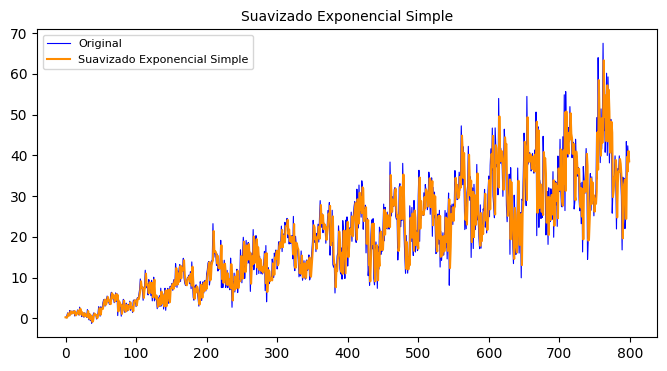

In [32]:
# Aplicar suavizado exponencial simple
model_suavizado1 = ExponentialSmoothing(df['serie'], trend=None, seasonal=None, damped_trend=False, seasonal_periods=None)
model_suavizado1 = model_suavizado1.fit(smoothing_level=0.8)  # Ajusta el smoothing_level según sea necesario

# Predicción
predictions1 = model_suavizado1.fittedvalues

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(df['serie'], label='Original', color='blue', linewidth=0.8)
plt.plot(predictions1, label='Suavizado Exponencial Simple', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Simple', fontsize=10)
plt.legend(fontsize=8)
plt.show()

Aquí vemos que prácticamente no se suaviza nada el ruido, se mantienen todas las subidas y bajadas casi replicando la serie. Si nos vamos ahora al otro extremo, con un alfa de 0.05 vamos a ver que pinta tiene el suavizado.

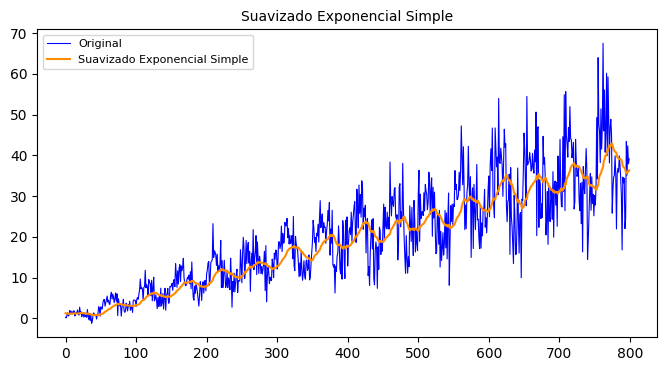

In [33]:
# Aplicar suavizado exponencial simple
model_suavizado1 = ExponentialSmoothing(df['serie'], trend=None, seasonal=None, damped_trend=False, seasonal_periods=None)
model_suavizado1 = model_suavizado1.fit(smoothing_level=0.05)  # Ajusta el smoothing_level según sea necesario

# Predicción
predictions1 = model_suavizado1.fittedvalues

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(df['serie'], label='Original', color='blue', linewidth=0.8)
plt.plot(predictions1, label='Suavizado Exponencial Simple', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Simple', fontsize=10)
plt.legend(fontsize=8)
plt.show()

En este caso, se ve muchisimo más suave la serie ya que no atiende prácticamente al valor más reciente de la serie original, y sin embargo, le da casi todo el peso a los valores suavizados anteriores. Al darle tanto peso al suavizado, lo que está ocurriendo además es que la serie suavizada está en cierto grado desplazada respecto de la original, es como si fuera tarde. Para cuando la serie suavizada alcanza un máximo, la otra ya ha empezado a bajar. Esto es por que tiene muchisimo más peso los valores anteriores que el actual y eso tiene este reflejo. Por otro lado, se va perdiendo la amplitud de la serie. Esto es debido a que al dar ese peso al suavizado, casi no se incorpora información actualizada y por ello se va perdiendo y cada vez se aleja más de la realidad pasando a ser prácticamente plano, una recta en la que se persigue a cada paso el valor suavizado anterior en vez de seguir la serie real.

Ahora vamos a dividir el conjunto de datos en 2 conjuntos: uno para entrenar (en realidad no es entrenar, es más bien ajustar el modelo a la serie) con todos los puntos salvo los 30 últimos, y los 30 restantes por separado en otro conjunto para ver que tal predice.

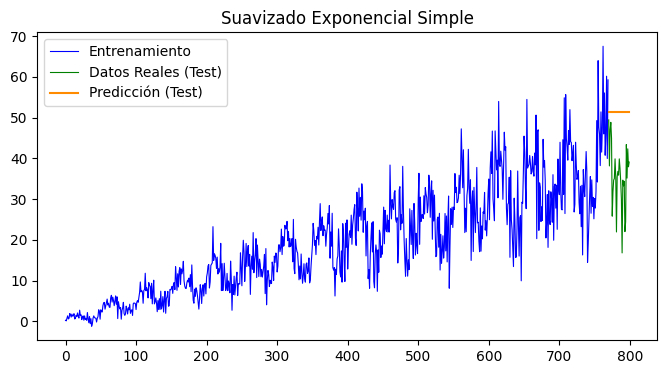

In [34]:
# Dividir los datos: 30 puntos de test (últimos 30 días) y el resto de los datos para entrenamiento
train = df['serie'][:-30]
test = df['serie'][-30:]

# Entrenar el modelo de suavizado exponencial simple
model_suavizado1_2 = ExponentialSmoothing(train, trend=None, seasonal=None)
model_suavizado1_2 = model_suavizado1_2.fit()

# Predicción para los próximos 30 puntos (el test set)
predictions1_2 = model_suavizado1_2.forecast(steps=30)

# Graficar los resultados
plt.figure(figsize=(8, 4))
plt.plot(train, label='Entrenamiento', color='blue', linewidth=0.8)
plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=0.8)
plt.plot(test.index, predictions1_2, label='Predicción (Test)', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Simple')
plt.legend()
plt.show()

Lo que obtenemos como predición con este modelo de suavizado es una línea recta que comienza en el último punto suavizado y avanza indefinidamente con pendiente cero. Esto es así por varias razones: primero, al ser un modelo simple, no captura la tendencia ni la estacionalidad, por lo que está pensado para series con un nivel constante. Este nivel constante es capaz de captarlo. Y por otro lado, este modelo calcula cada punto a partir del valor real de la serie en el momento 't' que está estimando multiplicado por el factor alfa, y luego le suma el valor suavizado, mulitplicado por (1-alfa), del punto inmediatamente anterior. Cuando hacemos predicciones, no conocemos ni disponemos del valor real de la serie, por lo que al intentar calcular nuevos valores, esa suma tiene uno de los 2 sumandos a cero (el del valor de la serie original en el momento t+m). Por tanto no tiene información nueva y el calculo se basa en el otro sumando únicamente. Al ser el mismo valor a partir de ese momento de forma indefinida, el valor que predice también será el mismo siendo una recta de pendiente 0.

Vamos a probar ahora con el suavizado exponencial doble.

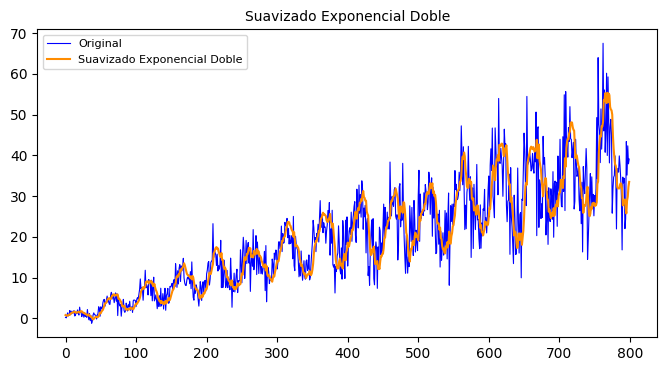

In [35]:
# Suavizado exponencial doble (Holt)
model_suavizado2 = ExponentialSmoothing(df['serie'], trend='add', seasonal=None, damped_trend=False, seasonal_periods=None)
model_suavizado2 = model_suavizado2.fit(smoothing_level=0.2, smoothing_trend=0.1)  # Ajusta estos parámetros

# Predicción
predictions2 = model_suavizado2.fittedvalues

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(df['serie'], label='Original', color='blue', linewidth=0.8)
plt.plot(predictions2, label='Suavizado Exponencial Doble', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Doble', fontsize=10)
plt.legend(fontsize=8)
plt.show()

En este modelo, se incorpora un término que representa la tendencia o cambio en el nivel de la serie. Se suaviza también a través de un parametro, en este caso beta. El nivel de la serie se estima a partir del valor real observado multiplicado por alfa (igual que en el caso anterior simple) y se le suma el valor suavizado del punto anterior por (1 - alfa). En este caso, el valor suavizado anterior se estima como la suma del nivel suavizado anterior más un valor de tendencia suavizada también del punto anterior. Esta tendencia suavizada del punto anterior, es la que se calcula a partir de la diferencia de nivel entre los valores suavizados de 2 puntos anteriores multiplicando por beta. Aquí es donde es relevante beta. Cuanto mayor sea, mayor peso estamos dando a calcular el nivel de la serie sin tener en cuenta el valor suavizado de la tendencia. Si es más pequeño, entonces estaremos dando mayor peso a la tendencia suavizada que se va calculando, más que a los niveles en si suavizados. Es una forma de suavizar aún más dandole mayor peso a la tendencia de largo plazo que a los cambios más recientes en el suavizado.

Vamos a predecir 30 puntos de la serie a ver que pasa.

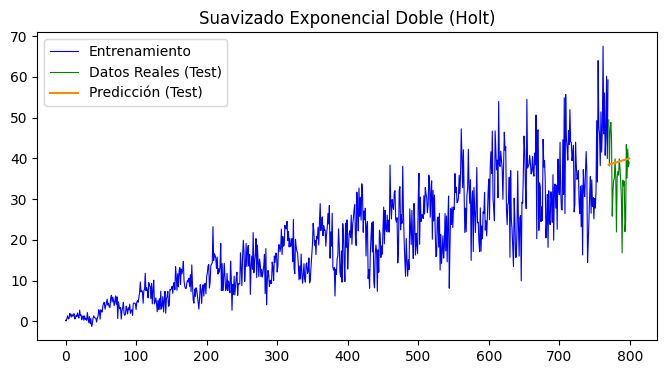

In [36]:
# Dividir los datos: 30 puntos de test (últimos 30 días) y el resto de los datos para entrenamiento
train = df['serie'][:-30]
test = df['serie'][-30:]

# Entrenar el modelo de suavizado exponencial doble (Holt)
model_suavizado2_2 = ExponentialSmoothing(train, trend='add', seasonal=None)
model_suavizado2_2 = model_suavizado2_2.fit(smoothing_level=0.005, smoothing_trend=0.01)

# Predicción para los próximos 30 puntos (el test set)
predictions2_2 = model_suavizado2_2.forecast(steps=30)

# Graficar los resultados
plt.figure(figsize=(8, 4))
plt.plot(train, label='Entrenamiento', color='blue', linewidth=0.8)
plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=0.8)
plt.plot(test.index, predictions2_2, label='Predicción (Test)', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Doble (Holt)')
plt.legend()
plt.show()

En este caso, vemos que los valores predichos se sitúan todos en una linea recta de pendiente igual a la tendencia aproximada de largo plazo que sigue la serie. Esto va a depender mucho de los valores de alfa y beta que configuremos. Como hemos puesto valores de suavizado muy fuertes y la tendencia de la serie original de largo plazo es lineal, el modelo de suavizado capta muy bien esa tendencia de largo plazo y estima la pendiente de la recta con la misma que sigue la serie original.

Vamos a cambiar los valores del suavizado poniendo un valor de beta que no suavice nada la tendencia y haga caso siempre al cambio de nivel más reciente. Esto es poner beta con un valor de 0.9 por ejemplo y podemos mantener alfa en 0.005.

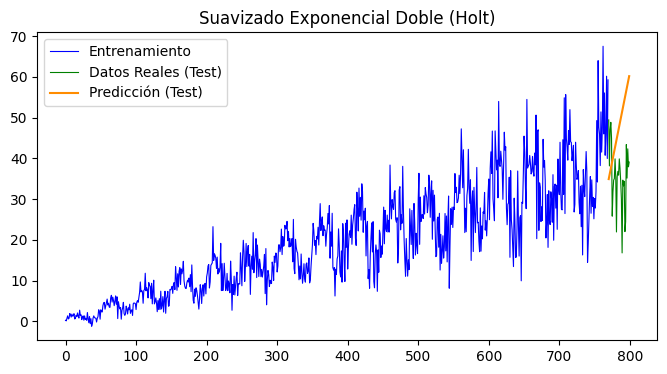

In [37]:
# Dividir los datos: 30 puntos de test (últimos 30 días) y el resto de los datos para entrenamiento
train = df['serie'][:-30]
test = df['serie'][-30:]

# Entrenar el modelo de suavizado exponencial doble (Holt)
model_suavizado2_2 = ExponentialSmoothing(train, trend='add', seasonal=None)
model_suavizado2_2 = model_suavizado2_2.fit(smoothing_level=0.005, smoothing_trend=0.9)

# Predicción para los próximos 30 puntos (el test set)
predictions2_2 = model_suavizado2_2.forecast(steps=30)

# Graficar los resultados
plt.figure(figsize=(8, 4))
plt.plot(train, label='Entrenamiento', color='blue', linewidth=0.8)
plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=0.8)
plt.plot(test.index, predictions2_2, label='Predicción (Test)', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Doble (Holt)')
plt.legend()
plt.show()

En este caso, como la tendencia se está estimando a partir de la diferencia entre valores muy recientes, se le está dando más peso a la tendencia de corto plazo más que a la de largo. Esto hace que cuando predice los 30 nuevos valores, se queda con que la tendencia es muy parecida a uno de los cambios de nivel más recientes (cambios por la estacionalidad o incluso por el ruido) y le planta una pendiente en este caso desórbitada que nada tiene que ver con la tendencia de largo plazo de la serie. Por tanto, este suavizado no serviría para predecir ni siquiera por donde va a ir la serie siguiendo la tendencia de largo plazo.

Vamos a incorporar la estacionalidad como parametro en el suavizado para intentar capturar tambien estos movimientos y tenerlos en cuenta al predecir. Para eso usamos el usavizado triple o de Holt-Winters.

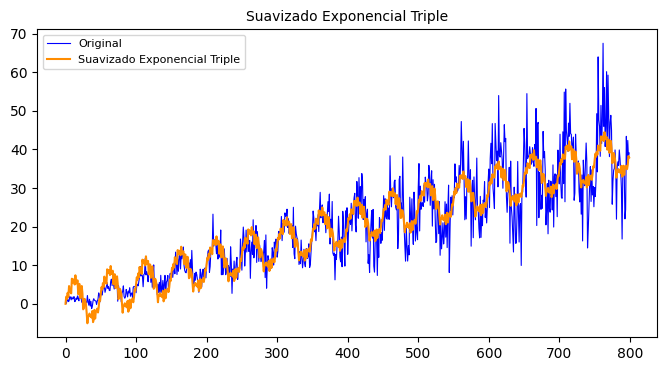

In [38]:
# Suavizado exponencial triple (Holt-Winters)
model_suavizado3 = ExponentialSmoothing(df['serie'], trend='add', seasonal='add', seasonal_periods=50)
model_suavizado3 = model_suavizado3.fit(smoothing_level=0.005, smoothing_trend=0.01, smoothing_seasonal=0.02)

# Predicción
predictions3 = model_suavizado3.fittedvalues

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(df['serie'], label='Original', color='blue', linewidth=0.8)
plt.plot(predictions3, label='Suavizado Exponencial Triple', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Triple', fontsize=10)
plt.legend(fontsize=8)
plt.show()

En la serie suavizada con todos sus valores, vemos que se sigue muy bien la tendencia, la estacionalidad y también el nivel de la serie. Elimina parte del ruido o al menos en amplitud. Los resultados no son malos. Se podrían cambiar los factores si se busca un suavizado que reduzca aún más el ruido.

Vamos a predecir los 30 valores.

C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


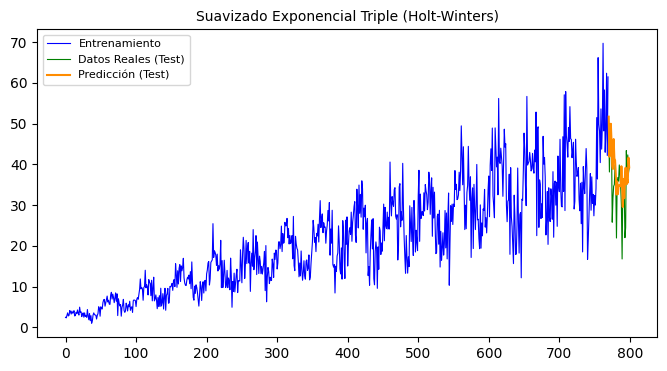

In [39]:
# Dividir los datos: 30 puntos de test (últimos 30 días) y el resto de los datos para entrenamiento
train = df['serie'][:-30]
offset = abs(train.min()) + 1  # Para que el mínimo sea mayor que cero
train = train + offset
test = df['serie'][-30:]

# Entrenar el modelo de suavizado exponencial triple (Holt-Winters)
model_suavizado3_2 = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=50)
model_suavizado3_2 = model_suavizado3_2.fit(smoothing_level=0.005, smoothing_trend=0.01, smoothing_seasonal=0.3)

# Predicción para los próximos 30 puntos (el test set)
predictions3_2 = model_suavizado3_2.forecast(steps=30)
# Invertir la transformación
predictions_original_scale = predictions3_2 - offset

# Graficar los resultados
plt.figure(figsize=(8, 4))
plt.plot(train, label='Entrenamiento', color='blue', linewidth=0.8)
plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=0.8)
plt.plot(test.index, predictions3_2, label='Predicción (Test)', color='darkorange', linewidth=1.5)
plt.title('Suavizado Exponencial Triple (Holt-Winters)', fontsize=10)
plt.legend(fontsize=8)
plt.show()

En este caso, con estos valores la tendencia la tenemos bien captada y el nivel, pero además estamos añadiendo la componente estacional y eso hace que captemos la amplitud de las oscilaciones estacionales con este modelo. Las prediciones son mucho mejores y no se limitan unicamente a predecir valores en base a la tendencia de largo plazo.

### Funciones de autocorrelación y autocorrelación parcial ###
Seguimos analizando nuestra serie temporal y para ello lo que hacemos es estudiar más en profundidad la función de autocorrelación. En este sentido, la ACF de nuestra serie original, dado que no es estacionaria, se aprecia claramente que su descenso es lento. Esto es un síntoma de no estacionariedad. Además los primeros retardos cuyo coeficiente de correlación es estadisticamente nulo, empiezan a aparecer a partir del retardo 65 o por ahí.

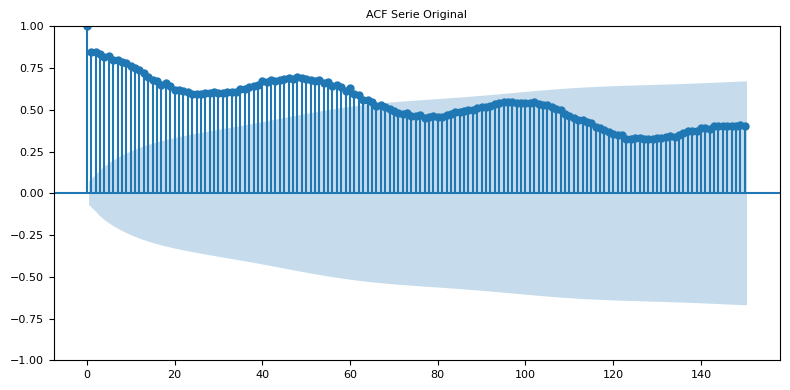

In [40]:
# Graficar ACF Serie original
plt.figure(figsize=(8, 4))
plot_acf(df['serie'].dropna(), lags=150, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Serie Original', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Vamos a mostrar ahora la función de autocorrelación de una serie con estacionalidad clara. Para ello hacemos uso de la componente de estacionalidad que habíamos extraido de nuestra serie original. Al ser una componente puramente estacional de periodo 50 y con una forma de función senoidal, la función de autocorrelación muestra claramente esta estacionalidad en su correlograma. 

La idea es que a lo largo de 50 puntos (50 es lo que dura un periodo completo), según vamos calculando la correlación de la serie con sus primeros 50 retardos, podemos ver como cuando estamos en los retardos 12 y 13 (esto es la cuarta parte del periodo), tenemos un coeficiente de correlación nulo. Esto se da porque la correlación entre la función seno y la misma función desplazada un cuarto de periodo, cuando una sube, la mitad de las veces la otra baja y la otra mitad sube, y viceversa. esto hace que no haya correlación o sea nula.

Sin embargo, cuando nos acercamos al retardo 25 (la mitad del periodo). La correlación entre estas 2 series es total pero inversa. Es decir, cuando una sube la otra baja y cuando la una baja la otra sube. Siempre a la inversa. Por esta razón, su factor de correlación es -1.

Por último, en el retardo 50 nos encontramos con un valor máximo en torno al valor 1 del coeficiente de correlación. Esto es porque el periodo se ha cumpletado y comenzamo sun nuevo periodo. Como la serie es pura estacionalidad, sin tendencia ni ruido ni nada, la correlación entre retardos desfasados un multiplo del periodo, es máxima e igual a 1. Esto ocurre cada 50 puntos en el caso de esta serie.

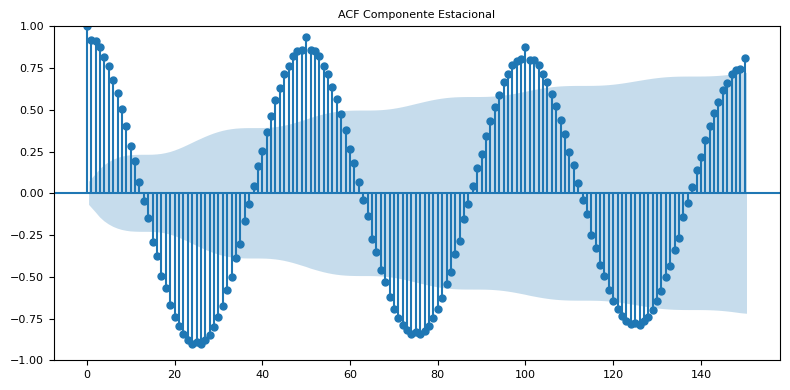

In [41]:
# Graficar ACF componente estacional
plt.figure(figsize=(8, 4))
plot_acf(df['seasonality_estimated'].dropna(), lags=150, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Componente Estacional', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Ejemplo de la pinta que tiene la función senoidal y la misma función desplazada un cuarto de periodo:

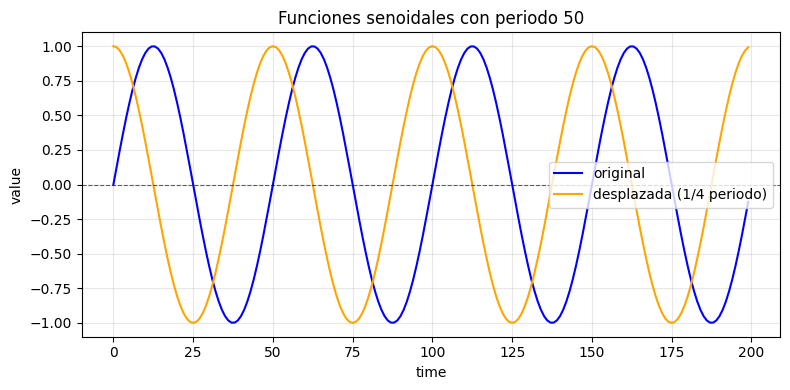

In [42]:
# Definimos el rango de valores para el eje temporal
time = np.arange(0, 200)

# Definimos las funciones senoidales
T = 50  # Periodo
y = np.sin(2 * np.pi * time / T)  # Función senoidal principal
ydesplazada = np.sin(2 * np.pi * time / T + np.pi / 2)  # Función desplazada un cuarto de periodo

# Creamos la gráfica
plt.figure(figsize=(8, 4))
plt.plot(time, y, label="original", color='blue')
plt.plot(time, ydesplazada, label="desplazada (1/4 periodo)", color='orange')

# Agregamos detalles a la gráfica
plt.title("Funciones senoidales con periodo 50")
plt.xlabel("time")
plt.ylabel("value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)  # Línea del eje y
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostramos la gráfica
plt.show()

La componente de tendencia cuando la obtenemos a partir de una media movil con ventana igual al periodo, tenía la forma de una línea recta con pendiente postiva fija. Si tratamos de analizar la ACF de esta componente de tendencia, lo que vemos es que, comenzando en 1, que sería la autocorrelación de la propia serie de tendencia entre ella misma, la función va descendeniendo lentamente a lo largo de una linea recta. Esto se da porque la relación que tiene cada punto con los distintos retardos va disminuyendo debido a que el nivel de la propia serie evoluciona de forma creciente con el tiempo. Es decir, dicho de otra manera, si un punto vale 1000 y el anterior vale 999, lo que influye el punto de 999 al de 1000 es bastante ya que son valores muy cercanos entre si y del mismo orden de magnitud. Sin embargo, el punto de valor 1000 con el retardo que se encuentre en el pasado lejano y tenga valor 1, pues no tiene mucha relación ya que el hecho de que ese punto valga 1 o valga 2, no tiene mucho impacto en el de 1000 que vale 3 órdenes de magnitud más. Por eso, va perdiendose la relación cuanto más nos alejamos y eso hace que la correlación sea linealmente descendente. Cada vez menor.

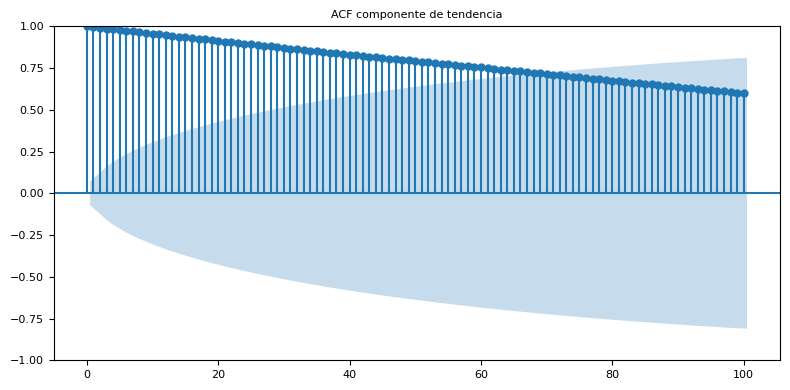

In [43]:
# Graficar ACF componente estacional
plt.figure(figsize=(8, 4))
plot_acf(df['trend_estimated'].dropna(), lags=100, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF componente de tendencia', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Vamos ahora a mostrar la autocorrelación de la componente de ruido. Para ello tomamos como referencia la componente de ruido del modelo multiplicativo que nos da un ruido puro estacionario y sin estacionalidad ni nada parecido.

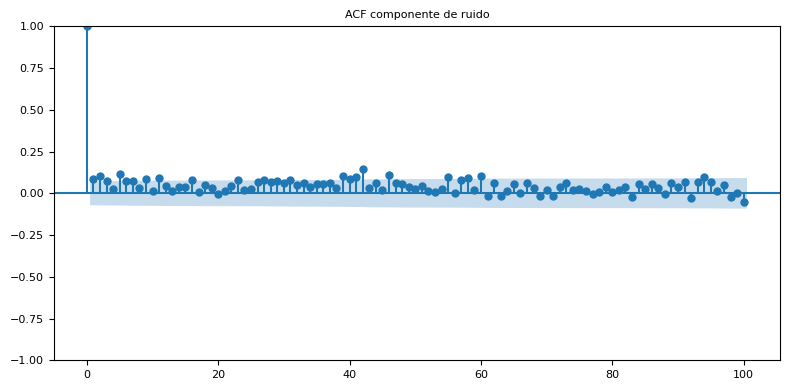

In [44]:
# Graficar ACF componente estacional
plt.figure(figsize=(8, 4))
plot_acf(df['noise_estimated_mult'].dropna(), lags=100, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF componente de ruido', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Aquí tenemos el efecto contrario. El ruido es una serie temporal en la que ninguno de sus valores se ve innfluido por lo valores pasados. Es completamente aleatorio e independientes entre si. Esto hace que la autocorrelación como siempre es igual a 1 en el retardo 0 (ella consigo misma), pero no hay correlación con ningún retardo. Ninguno de sus valores pasados aporta absolutamente ninguna información sobre el valor presente. Al contrario que con la tendencia que cuando la en un punto pasado vale 1, sabemos que mil retardos más adelante en el presente, su valor será 1000 veces mayor. Con el ruido esto no pasa, a partir de un punto es imposible que estime si valdrá más o menos.

Vamos a ver un ejemplo más de estacionalidad. En este caso vamos a crear una serie que tiene una estacionalidad que, en lugar de ser una función senoidal continua donde la media de un periodo es 0 porque se compensa lo que esta por encima con lo que hay por debajo del eje, en un punto concreto del periodo tiene un pico con un valor muy por encima del resto y luego se mantiene plano en valores bajos. Así en cada periodo.

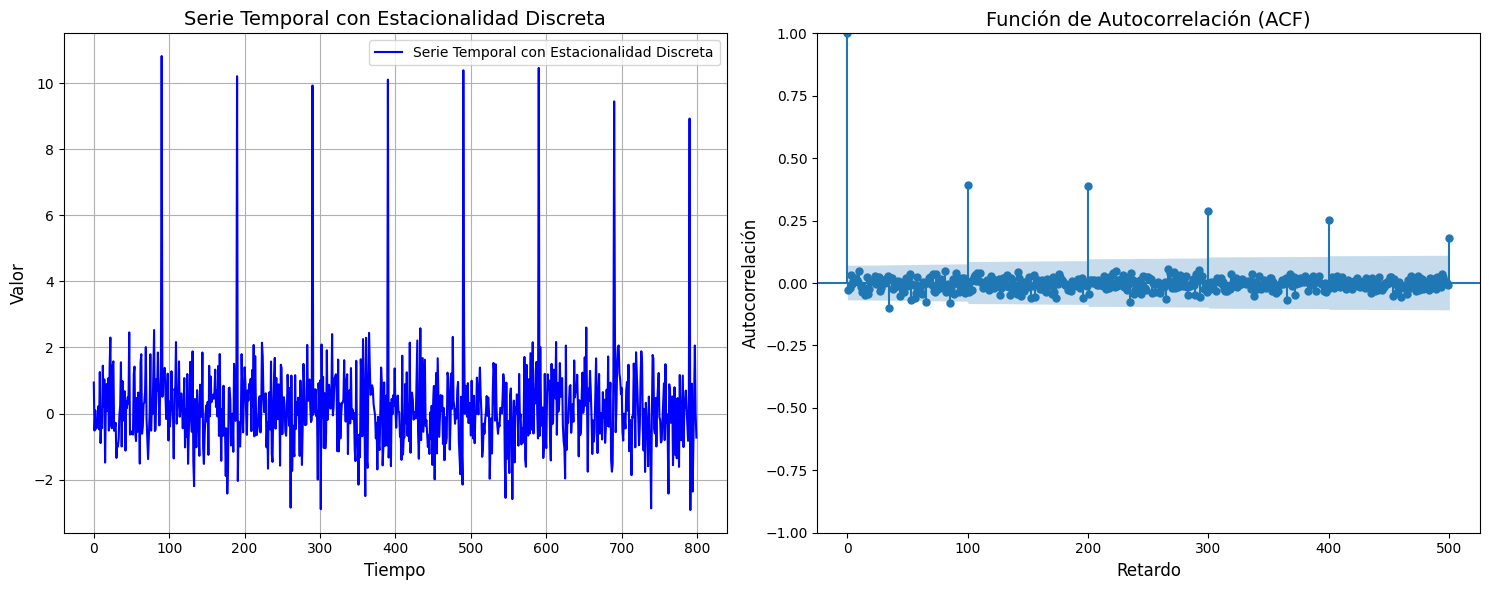

In [45]:
# Parámetros
n = 800  # Número de puntos de la serie temporal
periodo_estacional = 100  # Periodo de la estacionalidad (cada 50 pasos)
ruido_blanco = np.random.normal(loc=0, scale=1, size=n)  # Ruido blanco (componente aleatorio)

# Generar la serie temporal con estacionalidad discreta
serie_estacionaria = ruido_blanco.copy()

# Crear puntos que sobresalgan en ciertos intervalos (por ejemplo, puntos altos)
for i in range(periodo_estacional - 10, n, periodo_estacional):  # Establecer los puntos altos
    serie_estacionaria[i] += 10  # Incremento de 5 para hacer que los puntos sobresalgan

# Crear la figura con dos subgráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Primer gráfico: Serie temporal con estacionalidad discreta
axs[0].plot(serie_estacionaria, label='Serie Temporal con Estacionalidad Discreta', color='b')
axs[0].set_title('Serie Temporal con Estacionalidad Discreta', fontsize=14)
axs[0].set_xlabel('Tiempo', fontsize=12)
axs[0].set_ylabel('Valor', fontsize=12)
axs[0].grid(True)
axs[0].legend()

# Segundo gráfico: ACF de la serie temporal
plot_acf(serie_estacionaria, lags=500, ax=axs[1], alpha=0.05)
axs[1].set_title('Función de Autocorrelación (ACF)', fontsize=14)
axs[1].set_xlabel('Retardo', fontsize=12)
axs[1].set_ylabel('Autocorrelación', fontsize=12)

plt.tight_layout()
plt.show()


Se puede ver contando los picos de la serie, el número de periodos y también se ve claramente la forma de cada uno de ellos. Lo interesante en este caso es que la serie cuando la desplazamos un retardo y la correlamos con la original, su coeficiente de correlación es 0 puesto que cuando una sube la otra se queda donde mande el ruido, es decir, a saber donde. Esto ocurre con todos los retardos. Sin embargo cuando correlamos la serie original con un retardo que sea múltiplo del periodo, ocurre que hay una correlación muy alta entre ambas porque coincide que cuando una se encuentra con el pico de subida, la otra también y por tanto varian en la misma dirección y en el mismo momento y con la misma intensidad casi. Esto hace que cada periodo nos encontremos en la ACF estos picos. Entre medias no, porque no hay relación alguna estimable.

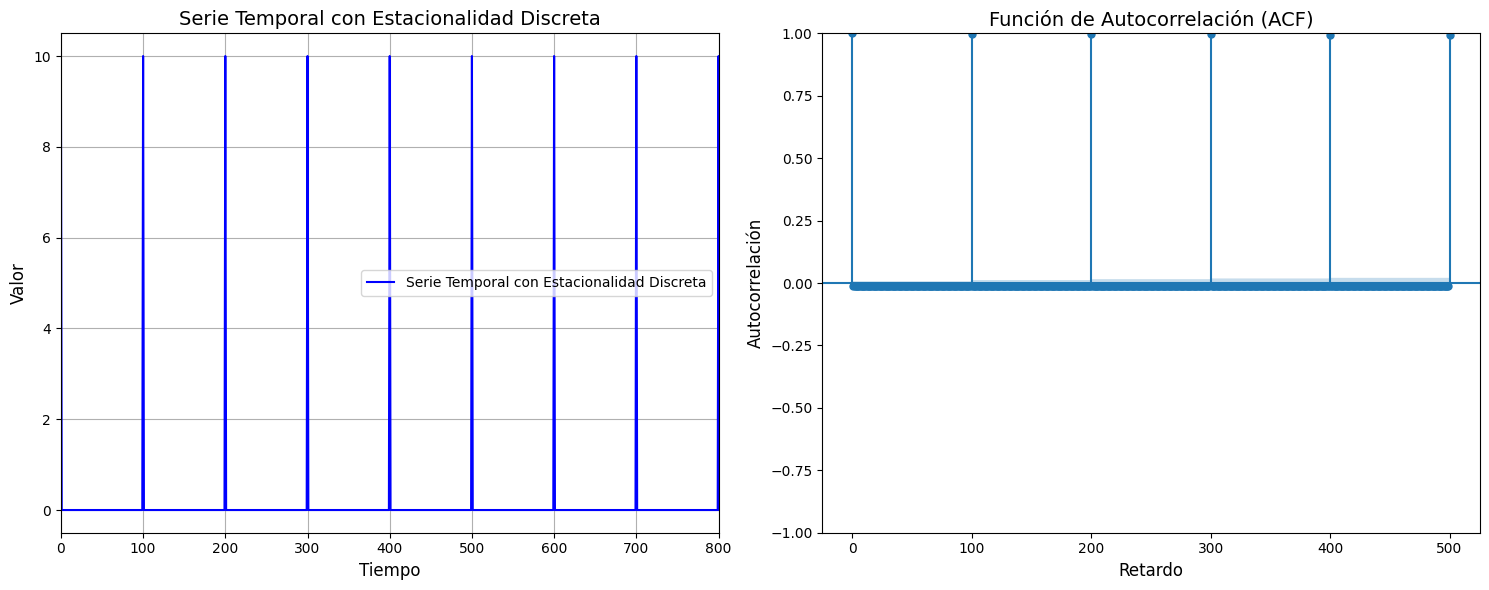

In [46]:
# Parámetros
n = 80000  # Número de puntos de la serie temporal
periodo_estacional = 100  # Periodo de la estacionalidad (cada 50 pasos)
ruido_blanco = np.random.normal(loc=0, scale=0, size=n)  # Ruido blanco (componente aleatorio)

# Generar la serie temporal con estacionalidad discreta
serie_estacionaria_2 = ruido_blanco.copy()

# Crear puntos que sobresalgan en ciertos intervalos (por ejemplo, puntos altos)
for i in range(int(-n/2), int(n/2), periodo_estacional):  # Establecer los puntos altos
    serie_estacionaria_2[i] += 10  # Incremento de 5 para hacer que los puntos sobresalgan

# Crear la figura con dos subgráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Primer gráfico: Serie temporal con estacionalidad discreta
axs[0].plot(serie_estacionaria_2, label='Serie Temporal con Estacionalidad Discreta', color='b')
axs[0].set_title('Serie Temporal con Estacionalidad Discreta', fontsize=14)
axs[0].set_xlabel('Tiempo', fontsize=12)
axs[0].set_ylabel('Valor', fontsize=12)
axs[0].set_xlim(0,800)
axs[0].grid(True)
axs[0].legend()

# Segundo gráfico: ACF de la serie temporal
plot_acf(serie_estacionaria_2, lags=500, ax=axs[1], alpha=0.05)
axs[1].set_title('Función de Autocorrelación (ACF)', fontsize=14)
axs[1].set_xlabel('Retardo', fontsize=12)
axs[1].set_ylabel('Autocorrelación', fontsize=12)

plt.tight_layout()
plt.show()

En esta otra versión, hemos eliminado el ruido para ver que ocurre con los retardos en los periodos de estacionalidad cuando tenemos una serie muy larga respecto al tamaño del periodo (80.000 puntos en total respecto a un periodo de 100) y también lo que ocurre al no haber ruido. El hecho de no haber ruido sube los retardos de multiplos del periodo a factores de autocorrelación igual a 1. Al no haber ruido, la correlación cuando deplazamos la serie y hacemos coincidir periodos, es máxima. también ayuda a que no decaigan lentamente estos valores, el tamaño de la serie. Al tener un tamaño muy largo (80.000 puntos), respecto del periodo, hay mucho para solapar sin que los bordes de la serie entren en juego de forma significativa. Por eso decrecen muy letamente.

Vamos a pasar a profundizar en la función de autocorrelación parcial (PACF). En primer lugar mostraremos la PACF de la serie original.

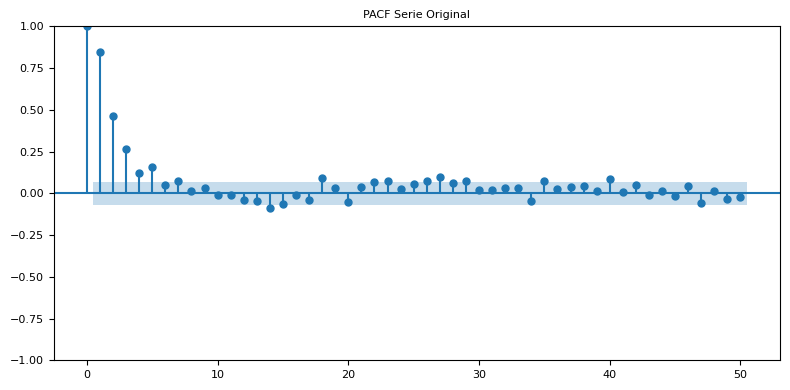

In [47]:
# Graficar PACF Serie original
plt.figure(figsize=(8, 4))
plot_pacf(df['serie'].dropna(), lags=50, ax=plt.gca())  # Ajustar el número de lags
plt.title('PACF Serie Original', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Al visualizar la PACF de nuestra serie original, lo que vemos es que tenemos algunos retardos (los 5 primeros) que tienen un coeficiente de autocorrelación significativamente distinto de cero. Lo que esto significa es que mi serie, si la quiero modelar a partir de los elementos pasados, tendré que incluir los primeros 5 términos. Es decir, que está determinada por lo que les pase a los 5 puntos inmediatamente anteriores. 

Puesto que tenemos una serie no estacionaria, tiene sentido que tengamos unos cuantos puntos significativos ya que nuestra serie se ve influida por eventos pasados.

Veamos ahora que le ocurre a la PACF de la componente estacional por separado.

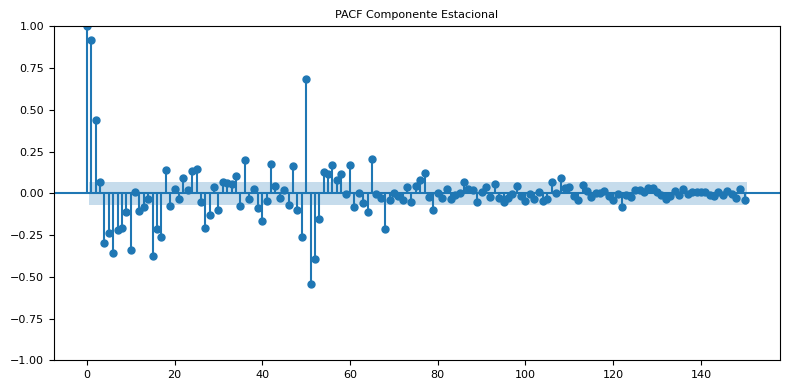

In [48]:
# Graficar PACF componente estacional
plt.figure(figsize=(8, 4))
plot_pacf(df['seasonality_estimated'].dropna(), lags=150, ax=plt.gca())  # Ajustar el número de lags
plt.title('PACF Componente Estacional', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Esta es más dificil de interpretar. Pero lo que es seguro es que tenemos un pico enorme en el punto 50 que justo coincide con nuestro periodo estacional. Esto viene a decirnos que si modelamos con una regresion que incluye como variables independientes los 49 retardos entre el 50 y el presente, el error cometido al estimar mi valor presente con estos 49 valores anteiores, es una serie que se comporta casi igual que el retardo 50. Es decir, que la variabilidad no explicada por esa regresión de 49 coeficientes, esta altamente correlada con lo que ocurrió hace 50 valores. Y en retardos intermedios, lo que vemos en la PACF muestra bastante variabilidad: unos retardos explican mejor que otros el error cometido en una regresión lineal a base de los retardos intermedios entre dicho punto y el presente. Al final el carácter senoidal de nuestra serie, hace que vaya bastantes retardos significativos en esta gráfica.

A ver la pinta de la PACF en la componente de tendencia.

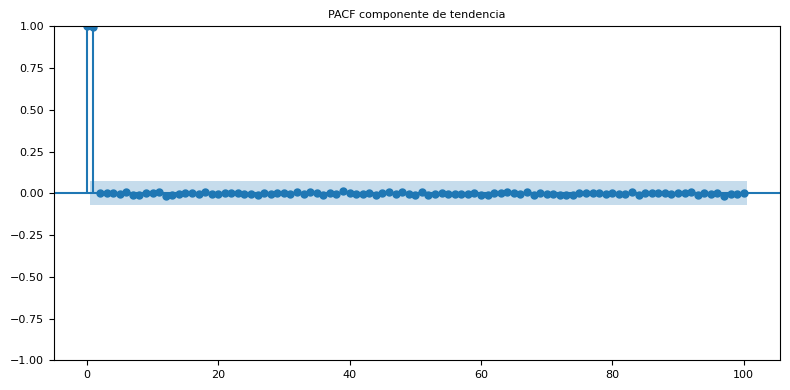

In [49]:
# Graficar PACF componente de tendencia
plt.figure(figsize=(8, 4))
plot_pacf(df['trend_estimated'].dropna(), lags=100, ax=plt.gca())  # Ajustar el número de lags
plt.title('PACF componente de tendencia', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Vaya!! aquí la cosa se pone interesante. La PACF indica que tenemos un único retardo con un coeficiente de correlación significativo. Este retardo es el primero y tiene una correlación altísima. Qué significa esto? basicamente que al ser una serie puramente tendencia, solo sube. Es decir, es una pendiente constante y que por tanto en realidad solo depende del valor anterior. Si hacemos una regresión lineal que sea solo intercepto, sin variables independientes, el error que cometo tiene una correlación altísima con el primer retardo. Es decir, que la variabilidad no explicada por un modelo sin variables independientes, está muy correlacionada con la serie retardada un punto. Sin embargo, si modelo con un único coeficiente mi regresión lineal y el error que cometo lo correlo con el segundo retardo, no hay correlación alguna. Es cero. La variabilidad no explicada por mi modelo de un único retardo (el primero), no tiene nada que ver con la variabilidad del retardo 2. Ni tampoco con la del 3, ni el 4. Es decir, si hay algo sin explicar, es puro ruido que no es capaz de explicar ningún retardo anterior al retardo 1.

Veamos ahora la otra estacional, la del pico.

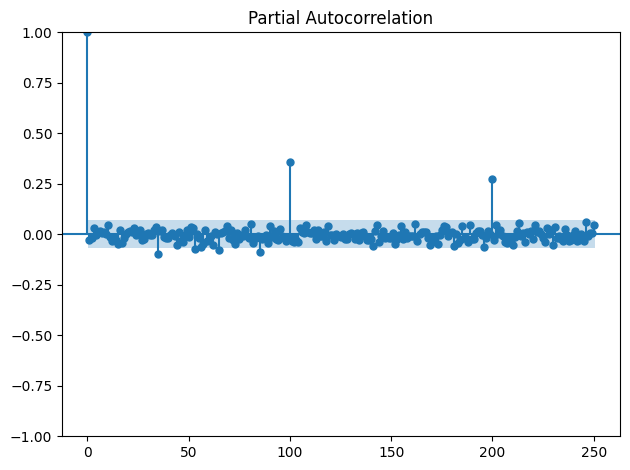

In [50]:
# PACF de la serie temporal estacional de periodo 100 con pico en valor 100
plot_pacf(serie_estacionaria, lags=250, alpha=0.05)
axs[1].set_title('Función de Autocorrelación (PACF)', fontsize=10)
axs[1].set_xlabel('Retardo', fontsize=8)
axs[1].set_ylabel('Autocorrelación', fontsize=8)

plt.tight_layout()
plt.show()

En este caso la PACF es muy parecida a la ACF. Se puede ver picos muy concretos en retardos coincidentes con los múltiplos del periodo. Esto es debido a que los residuos de una regresión lineal con los 99 puntos intermedios al primer retardo coincidente con el periodo (100), tiene una variabilidad muy correlada con la variabilidad del propio retardo del periodo.

Veamos ahora la PACF de la serie estacional de los picos cuando no presenta ruido y alargamos el número de valores de la serie a 80.000

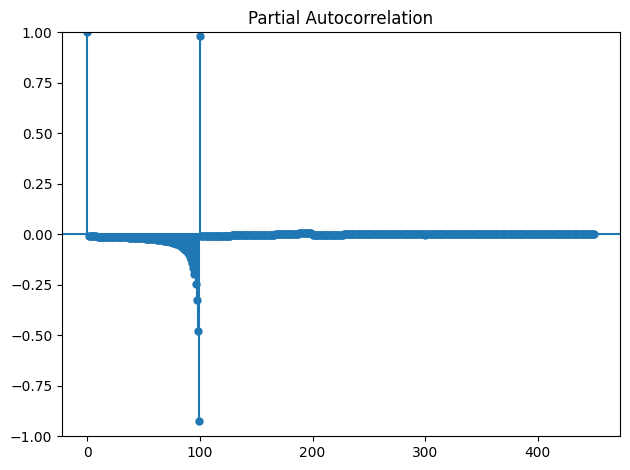

In [51]:
# PACF de la serie temporal estacional de periodo 100 con pico en valor 100
plot_pacf(serie_estacionaria_2, lags=450, alpha=0.05)
axs[1].set_title('Función de Autocorrelación (PACF)', fontsize=10)
axs[1].set_xlabel('Retardo', fontsize=8)
axs[1].set_ylabel('Autocorrelación', fontsize=8)

plt.tight_layout()
plt.show()

En este caso se puede ver que después del periodo 100, ningún múltiplo del periodo tiene valores significativos. Esto es porque el único retardo que de verdad contiene toda la información de la variabilidad de la serie original de forma directa, es el retardo 100. Los demás retardos multiplos de 100 no aportan nada nuevo de forma directa, lo hacen indirectamente a través del retardo 100. Por eso salen a 0 en la PACF. Por otro lado, los retardos inmediatamente anteriores al retardo 100, como se van acercando ya al solape, van mostrando cierto grado de correlación. Eso si, se muestran como correlación negativa, porque cuando una baja del pico, la otra en algún momento sube a su pico. Es una relación inversa por tanto. Y solo cuando solapan perfectamente en el retardo 100, se cumple que ambas suben al tiempo y bajan al tiempo también, es decir, correlación perfecta y positiva.

### Modelos Autoregresivos AR ###

Ahora vamos a estudiar los modelos AR. Son modelos autoregresivos, es decir, modelos que utilizan valores anteriores al valor actual como variables predictoras del valor presente. Cada retardo tendrá su coeficiente de regresión en función de la importancia que tenga y el sentido en que aporta (positivo o negativo).

Cogiendo en primer lugar la serie residual que nos quedaba tras quitar todas las componentes de nuestra serie original quedandonos solo con ruido estacionario, vamos a fijarnos en la PACF para determinar cuantos serían los retardos que debemos incluir como variables independientes en nuestro modelo AR.

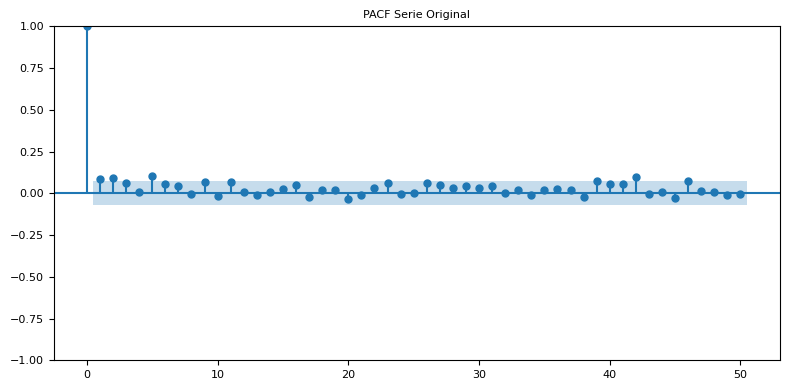

In [52]:
# Graficar PACF Serie original
plt.figure(figsize=(8, 4))
plot_pacf(df['noise_estimated_mult'].dropna(), lags=50, ax=plt.gca())  # Ajustar el número de lags
plt.title('PACF Serie Original', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Viendo la PACF, no parece que tengamos mucha elección, como no hay retardos con coeficiente de autocorrelación realmente significativos, lo que vamos a hacer es probar primer lugar con un modelo AR(1) que sería el mínimo que podemos ajustar.

C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


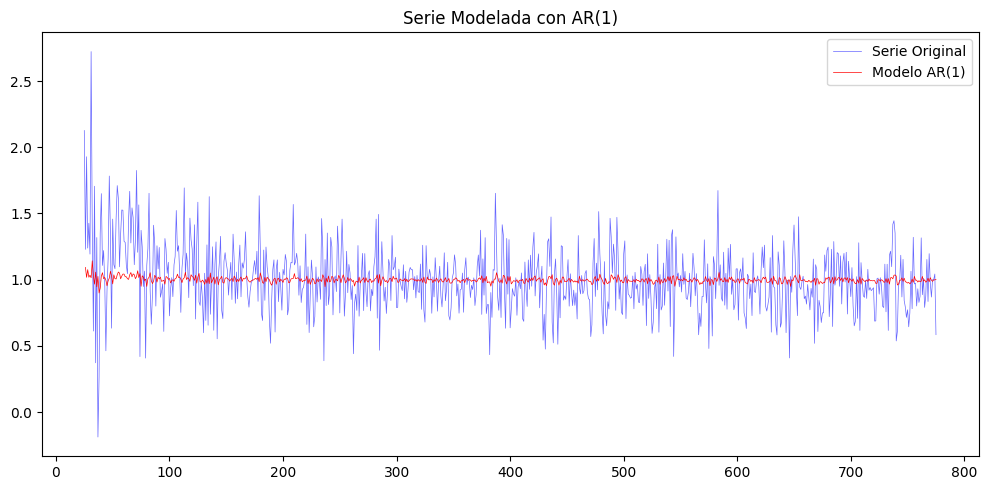

In [53]:
ar_order = 1

# Ajustar un modelo AR de orden especificado
model = AutoReg(df['noise_estimated_mult'].dropna(), lags=ar_order, old_names=False)
model_fit = model.fit()
serie_modelada = model_fit.fittedvalues

# Mostramos la gráfica de la serie original y la del modelo entrenado
plt.figure(figsize=(10, 5))
plt.plot(df['noise_estimated_mult'].dropna(), label="Serie Original", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(serie_modelada, label=f"Modelo AR({ar_order})", color="red", linewidth=0.5)
plt.title(f"Serie Modelada con AR({ar_order})")
plt.legend()

plt.tight_layout()
plt.show()

Si vemos la gráfica, se ve que efectivamente capta algo de ruido pero no lo entiende, solo sabe que está centrado en cero.

Veamos los resultados del entrenamiento para entender lo que está haciendo y cómo va a predecir:

In [54]:
# Función para imprimir los resultados de entrenamiento del modelo AR
def func_ar_results(ar_model):
    print('AR Lags: ', ar_model.ar_lags)
    print('Df Model: ', ar_model.df_model)
    print('Df Residuals: ', ar_model.df_resid)
    
    print('\nAIC: ', ar_model.aic)
    print('BIC: ', ar_model.bic)
    print('Log-Likelyhood: ', ar_model.llf)
    
    coefs = pd.DataFrame({
        "Coeficiente": ar_model.params,  # Valores de los coeficientes
        "Error Estándar": ar_model.bse,  # Errores estándar de los coeficientes
        "p-valor": ar_model.pvalues,  # p-valores asociados a los coeficientes
                         })
    print("\n", coefs)
    
    print('\nRaices pol. caracteristico: ', ar_model.roots)

In [55]:
# Mostrar resultados modelo AR(1)
func_ar_results(model_fit)

AR Lags:  [1]
Df Model:  2
Df Residuals:  748

AIC:  86.62810234923012
BIC:  100.48832196882118
Log-Likelyhood:  -40.31405117461506

                          Coeficiente  Error Estándar        p-valor
const                       0.914822        0.037192  1.360203e-133
noise_estimated_mult.L1     0.083629        0.035985   2.012572e-02

Raices pol. caracteristico:  [11.95759241]


Viendo los resultados, vemos que el coeficiente del retardo 1 tiene una importancia bastante baja en comparación con el intercepto. El intercepto, con un valor de 0.9148, levanta el nivel medio de la serie al entorno del 1 y luego le suma un 8% del valor anterior en la serie. Esto hace que capte algo del ruido ya que alguna variabilidad capta, pero no consigue quedarse con su amplitud. Solo capta el nivel medio de largo plazo.

Entrenamos el modelo sin los valores finales y los predecimos con el modelo para ver la pinta que tiene:

C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


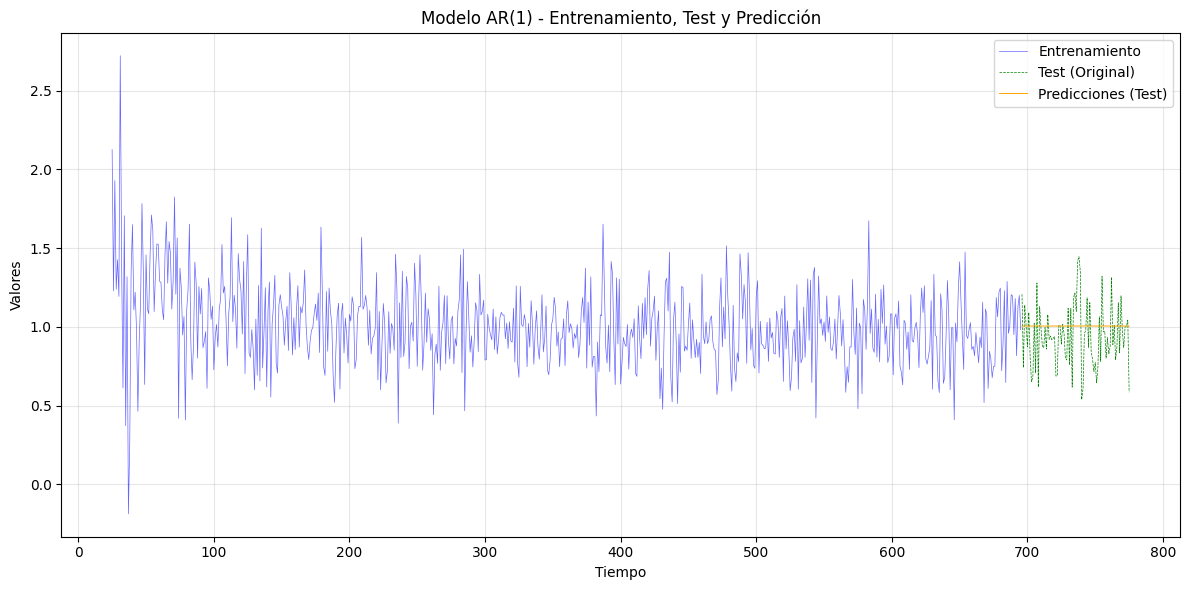

In [56]:
# Dividir la serie en conjunto de entrenamiento (todos los valores menos los últimos 80) y conjunto de test (últimos 80 valores)
train = df['noise_estimated_mult'].dropna()[:-80]
test = df['noise_estimated_mult'].dropna()[-80:]

# Ajustar el modelo AR(5) con el conjunto de entrenamiento
model = AutoReg(train, lags=1, old_names=False)
model_fit = model.fit()

# Predicción sobre el conjunto de test
test_pred_stationary = model_fit.predict(start=len(train), end=len(train) + 79)

# Graficar
plt.figure(figsize=(12, 6))

# Conjunto de entrenamiento
plt.plot(train.index, train, label="Entrenamiento", color="blue", alpha=0.6, linewidth=0.5)
# Conjunto de test (valores reales)
plt.plot(test.index, test, label="Test (Original)", color="green", linewidth=0.5, linestyle="--")
# Predicciones sobre el conjunto de test
plt.plot(test.index, test_pred_stationary, label="Predicciones (Test)", color="orange", linewidth=0.7)

# Personalización del gráfico
plt.title(f"Modelo AR(1) - Entrenamiento, Test y Predicción")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Valores")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Tal como esperabamos, el valor predicho es siempre igual a 1 prácticamente ya que la contribución del intercepto es la principal y la amplitud del ruido es constante e igual al último valor de los que se dispone.

Intentamos ahora modelar con un modelo AR la serie original. Para ello, basandonos en la PACF intentamos obtener el orden del modelo más apropiado.

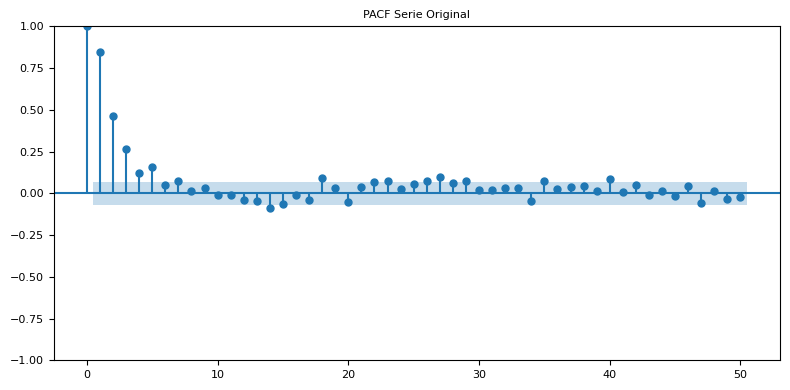

In [57]:
# Graficar PACF Serie original
plt.figure(figsize=(8, 4))
plot_pacf(df['serie'].dropna(), lags=50, ax=plt.gca())  # Ajustar el número de lags
plt.title('PACF Serie Original', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Puesto que paerce que tenemos 5 retardos significativos (quizá los 2 o 3 últimos no lo son mucho, pero por probar que no quede...), entrenamos el modelo sin los últimos valores y realizamos la predicción de los valores finales a ver que tal sale ocn un modelo AR(5).

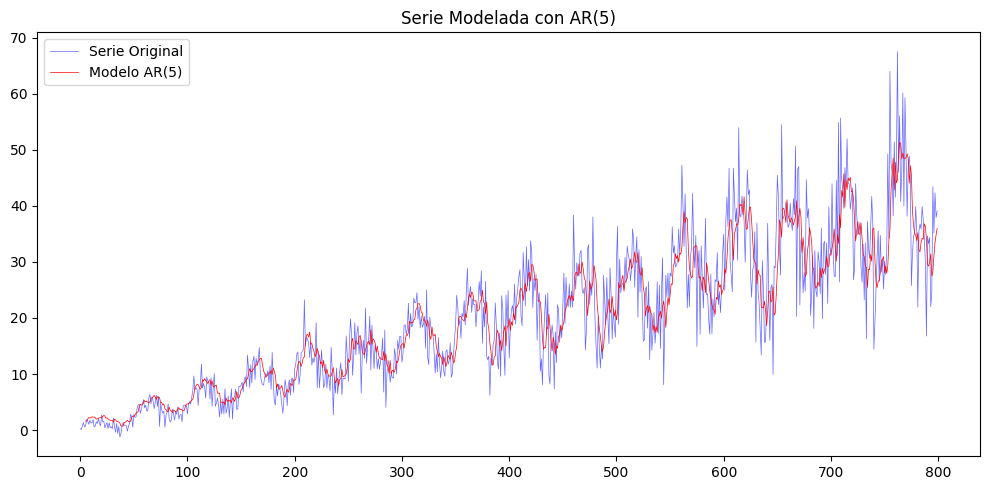

In [58]:
ar_order = 5

# Ajustar un modelo AR de orden especificado
model = AutoReg(df['serie'].dropna(), lags=ar_order, old_names=False)
model_fit = model.fit()
serie_modelada = model_fit.fittedvalues

# Mostramos la gráfica de la serie original y la del modelo entrenado
plt.figure(figsize=(10, 5))
plt.plot(df['serie'].dropna(), label="Serie Original", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(serie_modelada, label=f"Modelo AR({ar_order})", color="red", linewidth=0.5)
plt.title(f"Serie Modelada con AR({ar_order})")
plt.legend()

plt.tight_layout()
plt.show()

No tiene mala pinta, parece que capta la tendencia y la oscilación ya que se basa en los últimos 5 retardos, e incluso capta algo de ruido.

In [59]:
# Mostrar resultados modelo AR(1)
func_ar_results(model_fit)

AR Lags:  [1, 2, 3, 4, 5]
Df Model:  6
Df Residuals:  789

AIC:  5040.904917160392
BIC:  5073.653311962972
Log-Likelyhood:  -2513.452458580196

           Coeficiente  Error Estándar       p-valor
const        0.946661        0.386858  1.440293e-02
serie.L1     0.252875        0.034909  4.364737e-13
serie.L2     0.252788        0.035918  1.952436e-12
serie.L3     0.191867        0.036400  1.355788e-07
serie.L4     0.084673        0.035952  1.851568e-02
serie.L5     0.176612        0.034950  4.341471e-07

Raices pol. caracteristico:  [ 1.01580719-0.j         -1.1934114 -0.8820437j  -1.1934114 +0.8820437j
  0.44579337-1.52720092j  0.44579337+1.52720092j]


En este caso lo que vemos es que la serie con un modelo autoregresivo de orden 5, tiene todos sus coeficientes significativos (sus pvalores están muy por debajo de 0.05) y con un peso bastante repartido entre los 5. Esto tiene cierta lógica ya que al final lo que estamos modelando en esta serie es ruido. El ruido es aleatorio e independiente entre todos sus valores, por tanto, tiene sentido que el peso de unos valores y otros sean bastante similares. 

El problema es que todos los coeficientes (incluido el intercepto, son inferiores a 1 por lo que cuando hagamos predicciones, los valores predichos tenderán a decrecer con el tiempo. Es decir, el modelo de forma erronea capturará un patrón decreciente y extrapolará las predicciones con una tendencia decreciente.

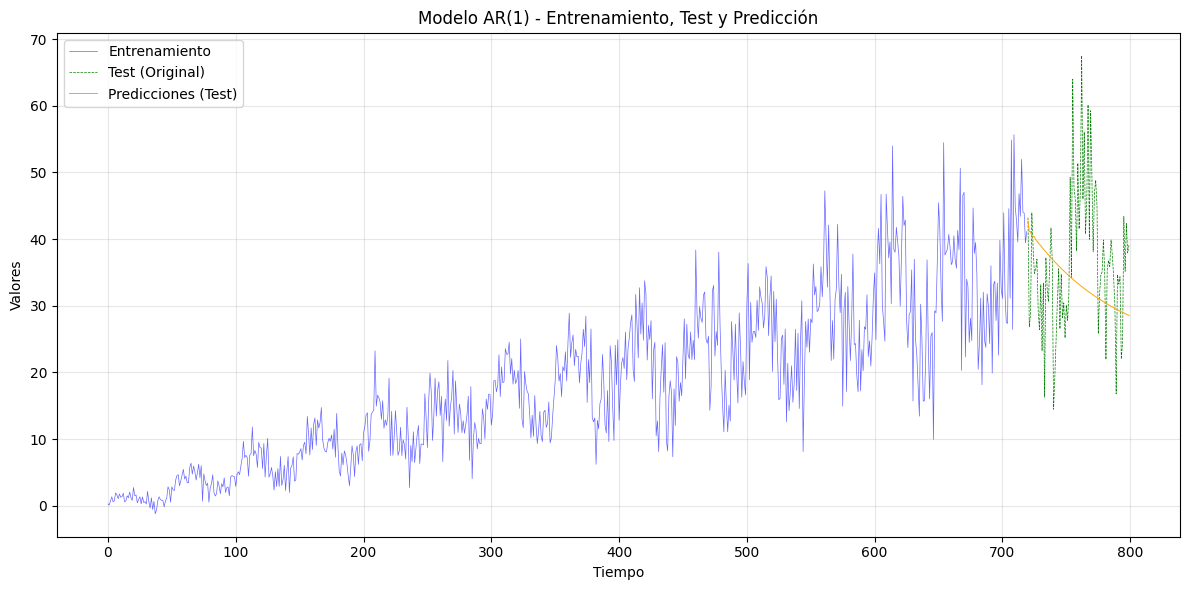

In [60]:
# Dividir la serie en conjunto de entrenamiento (todos los valores menos los últimos 80) y conjunto de test (últimos 80 valores)
train = df['serie'].dropna()[:-80]
test = df['serie'].dropna()[-80:]

# Ajustar el modelo AR(5) con el conjunto de entrenamiento
model = AutoReg(train, lags=5, old_names=False)
model_fit = model.fit()

# Predicción sobre el conjunto de test
test_pred_stationary = model_fit.predict(start=len(train), end=len(train) + 79)

# Graficar
plt.figure(figsize=(12, 6))

# Conjunto de entrenamiento
plt.plot(train.index, train, label="Entrenamiento", color="blue", alpha=0.6, linewidth=0.5)
# Conjunto de test (valores reales)
plt.plot(test.index, test, label="Test (Original)", color="green", linewidth=0.5, linestyle="--")
# Predicciones sobre el conjunto de test
plt.plot(test.index, test_pred_stationary, label="Predicciones (Test)", color="orange", linewidth=0.7)

# Personalización del gráfico
plt.title(f"Modelo AR(1) - Entrenamiento, Test y Predicción")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Valores")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Una serie no estacionaria no se puede modelar con un modelo de este tipo. Previamente habría que diferenciar la serie y eliminar la amplitud creciente que tenemos en las oscilaciones estacionales y en el propio ruido.

Vamos ahora a diseñar una serie sintética que sea estacionaria y que además tenga componente estacional y de ruido. Vamos a establecer un periodo de 50 y una amplitud constante tanto para las oscilaciones estacionales como para el ruido.

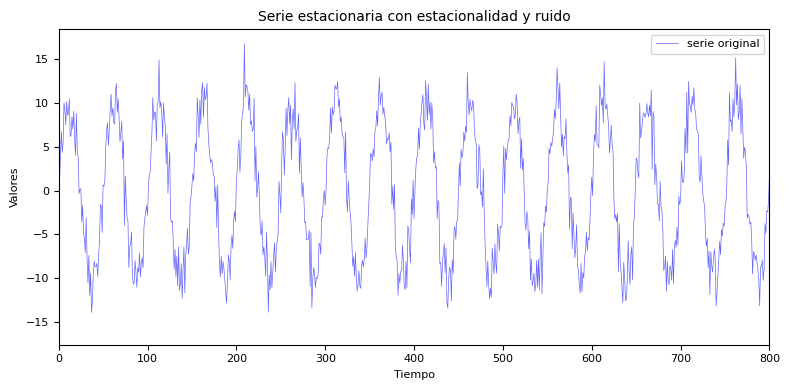

In [61]:
# Generación de una serie sintética estacionaria con componente estacional y ruido
np.random.seed(42)

# Definir parámetros
n = 8000  # Longitud de la serie
seasonal_period = 50  # Periodo estacional (patrón que se repite)
noise_amplitude = 2  # Amplitud del ruido
seasonality_amplitude = 10  # Amplitud de la estacionalidad

# Crear la serie con componente estacional y ruido
time = np.arange(-7200,800,1)
seasonality = np.sin(2 * np.pi * time / seasonal_period) * seasonality_amplitude
noise = np.random.normal(0, noise_amplitude, n)

# La serie sintética es la combinación de la estacionalidad y el ruido
series = seasonality + noise

# Convertir la serie en un DataFrame
df = pd.DataFrame(series, columns=['value'])

# Graficar
plt.figure(figsize=(8, 4))

# Personalización del gráfico
plt.plot(df.index, df['value'], label="serie original", color="blue", alpha=0.6, linewidth=0.5)
plt.title("Serie estacionaria con estacionalidad y ruido", fontsize=10)
plt.legend(fontsize=8)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valores", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,800)

plt.tight_layout()
plt.show()

La serie se como una función senoidal con periodo 50 y una componente de ruido por encima con una amplitud inferior a la de la estacionalidad. Entrenamos un modelo AR(1) para ver que nos devuelve:

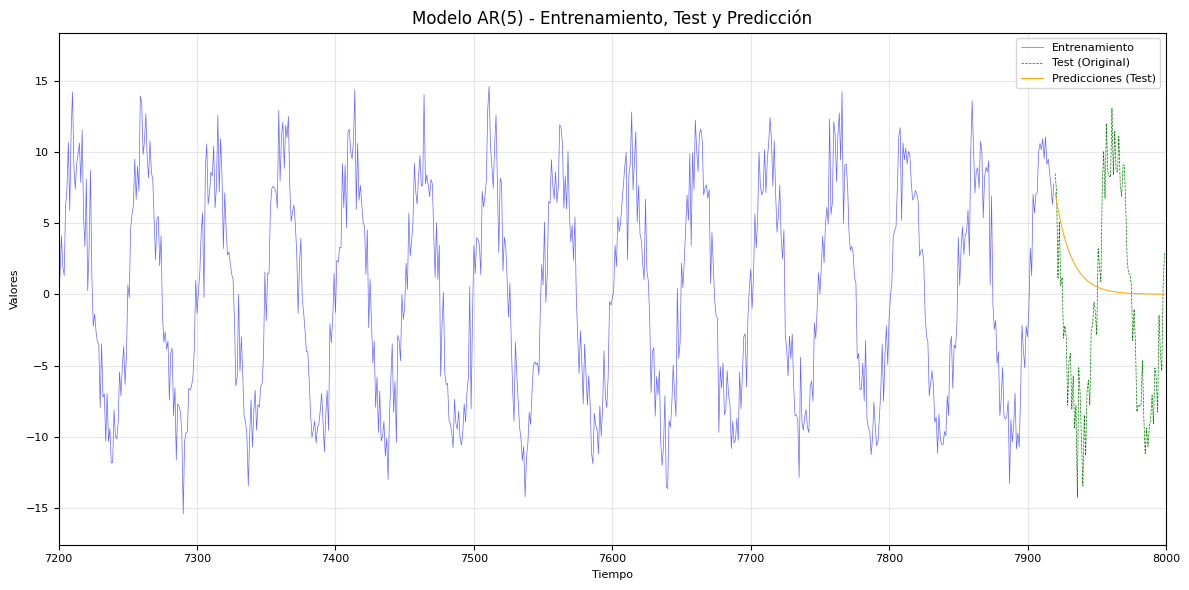

In [62]:
# Dividir la serie en conjunto de entrenamiento (todos los valores menos los últimos 80) y conjunto de test (últimos 80 valores)
train = df['value'][:-80]
test = df['value'][-80:]

# Ajustar el modelo AR(1) con el conjunto de entrenamiento
model = AutoReg(train, lags=1)
model_fit = model.fit()

# Predicción sobre el conjunto de test
test_pred_stationary = model_fit.predict(start=len(train), end=len(train) + 79)

# Graficar
plt.figure(figsize=(12, 6))

# Conjunto de entrenamiento
plt.plot(train.index, train, label="Entrenamiento", color="blue", alpha=0.6, linewidth=0.5)

# Conjunto de test (valores reales)
plt.plot(test.index, test, label="Test (Original)", color="green", linewidth=0.5, linestyle="--")

# Predicciones sobre el conjunto de test
plt.plot(test.index, test_pred_stationary, label="Predicciones (Test)", color="orange", linewidth=0.7)

# Personalización del gráfico
plt.title(f"Modelo AR(5) - Entrenamiento, Test y Predicción")
plt.legend(fontsize=8)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valores", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(7200,8000)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Las predicciones del modelo no son muy buenas ya que va decreciendo el valor predicho hasta que llega a cero y ahí se estabiliza y predice ese valor indefinidamente. viendo los coeficientes podemos entender un poco mejor este escenario.

In [63]:
# Mostrar resultados modelo AR(1)
func_ar_results(model_fit)

AR Lags:  [1]
Df Model:  2
Df Residuals:  7917

AIC:  39589.54603657625
BIC:  39610.47709721888
Log-Likelyhood:  -19791.773018288124

           Coeficiente  Error Estándar   p-valor
const        0.001276        0.033102  0.969256
value.L1     0.917063        0.004483  0.000000

Raices pol. caracteristico:  [1.09043755]


Viendo los coeficientes, vemos que el coeficiente único del retardo 1, es de 0.917. Es decir, que el valor actual lo calcula reduciendo el valor del punto anterior en un 91.7%. Esto lo hace indefinidamente hasta que llega a un punto en que el intercepto, cuyo valor es 0.0012, al sumarselo al valor reducido por el coeficiente, cancela el efecto de la reducción y se queda estable en un valor fijo muy cercano a 0. No es buen modelo, no capta nada de la serie y solo acaba centrando el tiro en el valor medio de la serie que, por ser estacionaria, tiene un nivel constante e igual a 0.

Vamos a ver que pinta tiene la PACF y la ACF

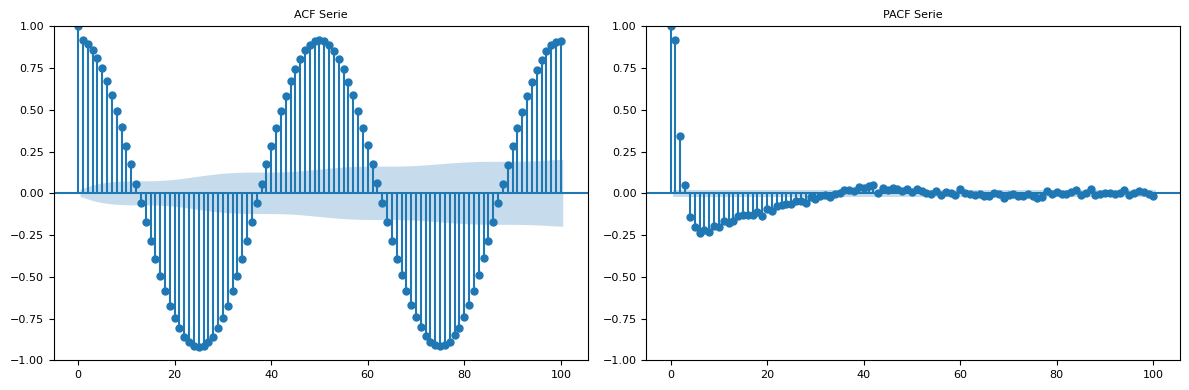

In [64]:
# Graficar ACF Serie original
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(df['value'].dropna(), lags=100, ax=plt.gca())  # Ajustar el número de lags
plt.title('ACF Serie', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Graficar ACF Residuo Aditivo
plt.subplot(1, 2, 2)
plot_pacf(df['value'].dropna(), lags=100, ax=plt.gca())  # Ajustar el número de lags
plt.title('PACF Serie', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

Según la PACF necesitamos unos 50 retardos para estimar correctamente la serie. Tiene lógica ya que el periodo es 50 y es lo más relevante que tiene como patrón la serie. Sin embargo, parece que la mayor parte de la información la tienen los retardos hasta el 25. Luego ya decae mucho la autocorrelación. Por tanto, vamos a modelar la serie con un AR(25) a ver que tal se comporta prediciendo valores futuros.

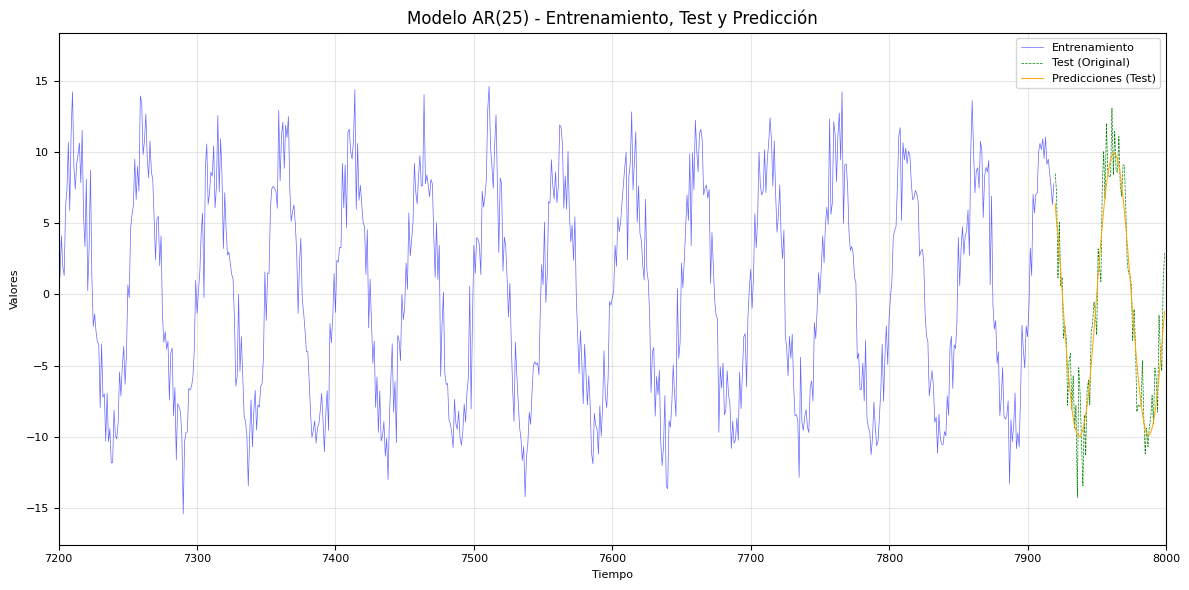

In [65]:
# Ajustar el modelo AR(25) con el conjunto de entrenamiento
model = AutoReg(train, lags=25)
model_fit = model.fit()

# Predicción sobre el conjunto de test
test_pred_stationary = model_fit.predict(start=len(train), end=len(train) + 79)

# Graficar
plt.figure(figsize=(12, 6))

# Conjunto de entrenamiento
plt.plot(train.index, train, label="Entrenamiento", color="blue", alpha=0.6, linewidth=0.5)

# Conjunto de test (valores reales)
plt.plot(test.index, test, label="Test (Original)", color="green", linewidth=0.5, linestyle="--")

# Predicciones sobre el conjunto de test
plt.plot(test.index, test_pred_stationary, label="Predicciones (Test)", color="orange", linewidth=0.7)

# Personalización del gráfico
plt.title(f"Modelo AR(25) - Entrenamiento, Test y Predicción")
plt.legend(fontsize=8)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valores", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(7200,8000)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Ahora nuestra serie predice con mucha precisión la serie. Ha captado bien el patrón detras de esta serie a partir de los retardos apropiados. Podríamos probar con menos retardos para ver si contienen información suficiente y seguramente así sea. Pero es cierto que iremos perdiendo parte de la amplitud cuántos menos retardos escojamos.

Los coeficientes se muestran a continuación. En ellos se puede ver que algunos son positivos y otros negativos. Esto es debido a que algunos retardos están correlados inversamente con la serie y otros de forma directa.

In [66]:
# Mostrar resultados modelo AR(25)
func_ar_results(model_fit)

AR Lags:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Df Model:  26
Df Residuals:  7869

AIC:  34117.704851599425
BIC:  34306.00244462005
Log-Likelyhood:  -17031.852425799712

            Coeficiente  Error Estándar       p-valor
const        -0.012328        0.023552  6.006690e-01
value.L1      0.064191        0.011221  1.061427e-08
value.L2      0.070303        0.011214  3.631458e-10
value.L3      0.084562        0.011215  4.694768e-14
value.L4      0.063923        0.011229  1.250237e-08
value.L5      0.075339        0.011210  1.812242e-11
value.L6      0.046282        0.011223  3.724503e-05
value.L7      0.066465        0.011190  2.857744e-09
value.L8      0.034232        0.011203  2.244816e-03
value.L9      0.048283        0.011194  1.609451e-05
value.L10     0.017078        0.011202  1.273770e-01
value.L11     0.029268        0.011202  8.982242e-03
value.L12    -0.004460        0.011205  6.906037e-01
value.L13    -0.017550        0.0

### Modelos de Medias Moviles MA ###

Pasamos ahora a estudiar los modelos de medias móviles que en lugar de utilizar como variables predictoras los valores de los retardos de la propia serie, utilizan los errores obtenidos en el cálculo de los retardos de la serie.

C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


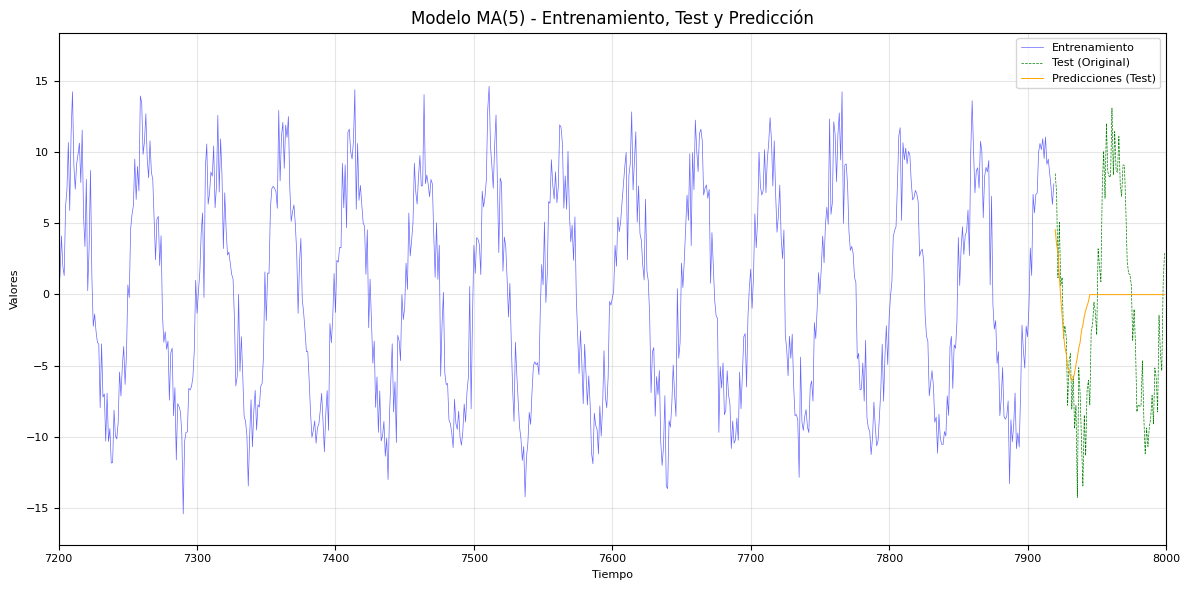

In [69]:
from statsmodels.tsa.arima.model import ARIMA
# Dividir la serie en conjunto de entrenamiento (todos los valores menos los últimos 80) y conjunto de test (últimos 80 valores)
train = df['value'][:-80]
test = df['value'][-80:]

# Ajustar el modelo MA(25) con el conjunto de entrenamiento
model = ARIMA(train, order=(0, 0, 25))  # ARIMA(p, d, q) -> (0, 0, 25) para MA(25)
model_fit = model.fit()

# Predicción sobre el conjunto de test
test_pred_ma = model_fit.predict(start=len(train), end=len(train) + 79, typ='levels')

# Graficar
plt.figure(figsize=(12, 6))

# Conjunto de entrenamiento
plt.plot(train.index, train, label="Entrenamiento", color="blue", alpha=0.6, linewidth=0.5)

# Conjunto de test (valores reales)
plt.plot(test.index, test, label="Test (Original)", color="green", linewidth=0.5, linestyle="--")

# Predicciones sobre el conjunto de test
plt.plot(test.index, test_pred_ma, label="Predicciones (Test)", color="orange", linewidth=0.7)

# Personalización del gráfico
plt.title(f"Modelo MA(5) - Entrenamiento, Test y Predicción")
plt.legend(fontsize=8)
plt.xlabel("Tiempo", fontsize=8)
plt.ylabel("Valores", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(7200,8000)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

En este caso, un modelo de medias móviles por mucho que sea de 25 retardos, no es un modelo apropiado para esta serie. Estos modelos son más especializados en movimientos de corto plazo con variaciones rápidas donde se obtienen patrones interesantes en los errores cometidos al estimar los coeficientes. De hecho, la ACF, que es donde podríamos encontrar el orden apropiado para el modelo, nos muestra que no tenemos un claro escalón que nos sirva para identificar el orden de un modelo de medias moviles. No se puede utilizar aquí en esta serie.

Mostramos a continuación un ejemplo de una serie que es más apropiada para un modelo de medias móviles. Se trata de una serie que tiene unas variaciones de corto plazo muy rápidas y que por tanto requieren de un modelo como este para poder detectarlas y entenderlas. En este caso se trata de una estacionalidad de frecuencia muy alta (periodo 4).

C:\Users\Carlos\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


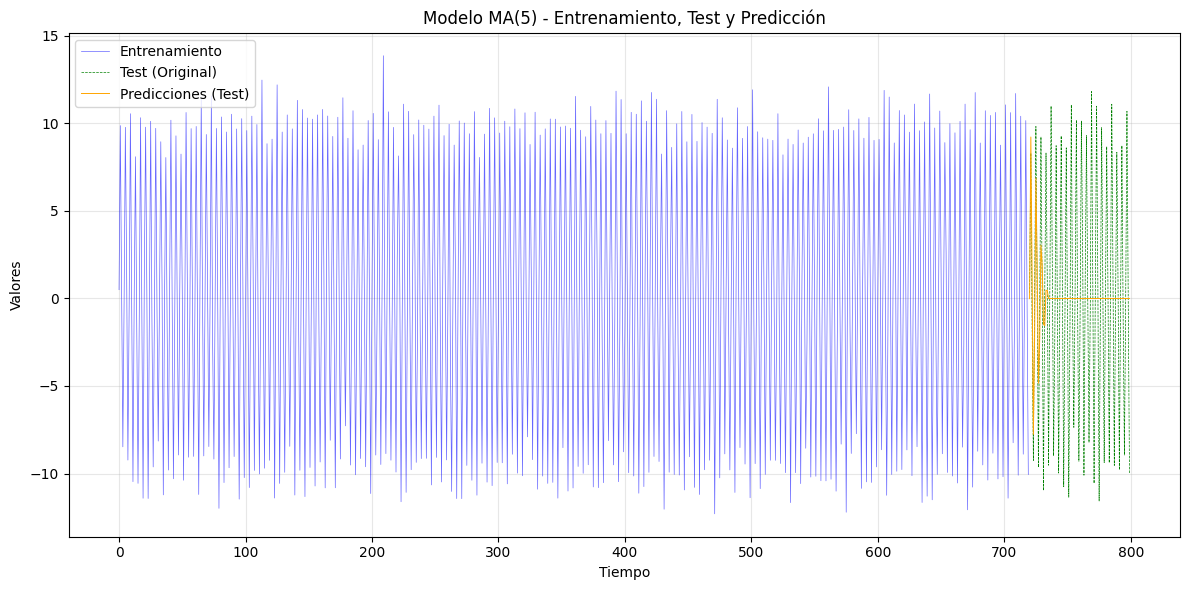

In [70]:
# Generación de una serie con un patrón más controlado para el modelo MA(5)
np.random.seed(42)

# Parámetros
n = 800  # Longitud de la serie
seasonal_period = 4  # Periodo estacional
amplitude = 10  # Amplitud de la estacionalidad
noise_std = 1  # Desviación estándar del ruido

# Generar componente estacional suave (variación de corta duración pero sutil)
seasonal_component = amplitude * np.sin(2 * np.pi * np.arange(n) / seasonal_period)

# Ruido controlado (baja frecuencia y menor amplitud)
noise_component = np.random.normal(0, noise_std, n)

# Combinación de los componentes: Estacionalidad + Ruido + Tendencia
series = seasonal_component + noise_component

# Convertir la serie en un DataFrame
df = pd.DataFrame(series, columns=['value'])

# Dividir la serie en conjunto de entrenamiento y conjunto de test
train = df['value'][:-80]
test = df['value'][-80:]

# Ajustar el modelo MA(5) con el conjunto de entrenamiento
model = ARIMA(train, order=(0, 0, 15))  # ARIMA(p, d, q) -> (0, 0, 5) para MA(5)
model_fit = model.fit()

# Predicción sobre el conjunto de test
test_pred_ma = model_fit.predict(start=len(train), end=len(train) + 79, typ='levels')

# Graficar
plt.figure(figsize=(12, 6))

# Conjunto de entrenamiento
plt.plot(train.index, train, label="Entrenamiento", color="blue", alpha=0.6, linewidth=0.5)

# Conjunto de test (valores reales)
plt.plot(test.index, test, label="Test (Original)", color="green", linewidth=0.5, linestyle="--")

# Predicciones sobre el conjunto de test
plt.plot(test.index, test_pred_ma, label="Predicciones (Test)", color="orange", linewidth=0.7)

# Personalización del gráfico
plt.title(f"Modelo MA(5) - Entrenamiento, Test y Predicción")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Valores")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Efectivamente en la gráfica podemos ver que durante los primeros valores, cuando hay muestras reales para estimar error y por tanto estimar el modelo de media movil, el modelo encaja bien el patrón de estacionalidad tan rapida que tiene y lo predice de una forma coherente. El problema es que no se le puede pedir predecir más allá puesto que se basa en los errores y necesita por tanto los valores reales. Este modelo está pensado para prediciones de muy corto plazo.

A continuación vamos a ver los modelos ARIMA como funcionan. Para ello generamos

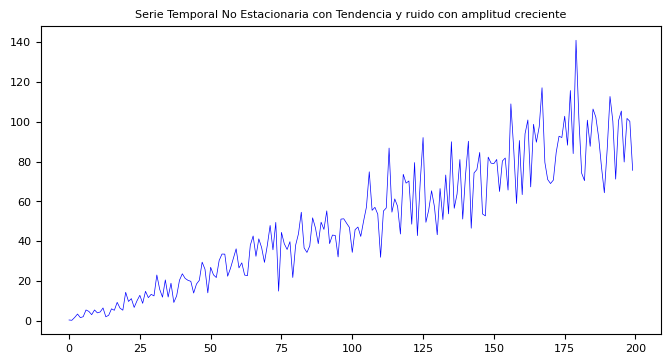

In [5]:
# Generación de la serie temporal no estacionaria con tendencia y amplitud creciente
np.random.seed(42)
n = 200
t = np.arange(n)
trend = 0.5 * t  # Tendencia lineal
noise = np.random.normal(loc=0, scale=1 + 0.1 * t, size=n)  # Ruido con amplitud creciente
series = pd.Series(trend + noise)

# Visualización de la serie original
plt.figure(figsize=(8, 4))
plt.plot(series, color='blue', linewidth=0.5)
plt.title('Serie Temporal No Estacionaria con Tendencia y ruido con amplitud creciente', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

La gráfica muestra la serie que vamos a tratar de modelar con un modelo ARIMA. Presenta tendencia creciente y ruido con una amplitud creciente con el tiempo. En primer lugar vamos a analizar las funciones de autocorrelación.

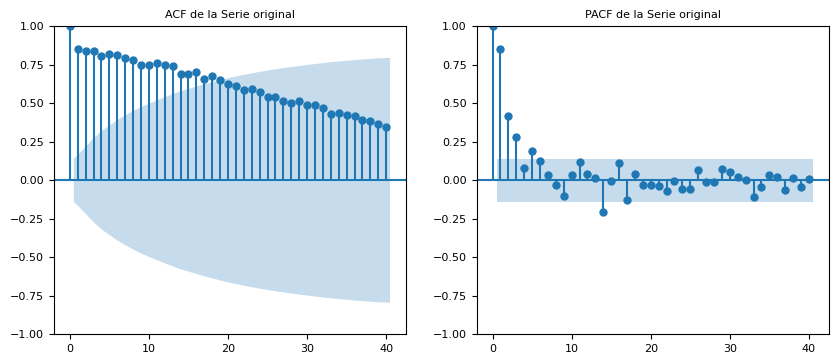

In [6]:
# ACF y PACF de la serie original
plt.figure(figsize=(10, 4))

# ACF con intervalo de confianza
plt.subplot(121)
plot_acf(series, lags=40, alpha=0.05, ax=plt.gca())
plt.title('ACF de la Serie original', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# PACF con intervalo de confianza
plt.subplot(122)
plot_pacf(series, lags=40, alpha=0.05, ax=plt.gca())
plt.title('PACF de la Serie original', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

A partir de la PACF, podemos obtener el orden para la parte autoregresiva del modelo. En este caso, un orden 3 podría ser suficiente dado que el resto de retardos tienen autocorrelación parcial nula o muy poco significativa. Sin embargo, la ACF muestra la misma forma que una serie que siguiera una recta de tendencia con pendiente constante. En esta gráfica no podemos determinar el posible orden de la parte de medias moviles del modelo ARIMA.

Teniendo en cuenta que esta serie presenta una varianza creciente, lo suyo es aplicar algún tipo de transformación que elimine esa varianza creciente dejandola constante. Probaremos con una transformación logaritmica a ver si ayuda a reducir este problema.

In [7]:
# Aplicar logaritmo a la serie original para reducir la amplitud de las fluctuaciones
log_transformed_series = np.log(series + abs(series.min()) + 1e-6)  # Asegurar valores positivos

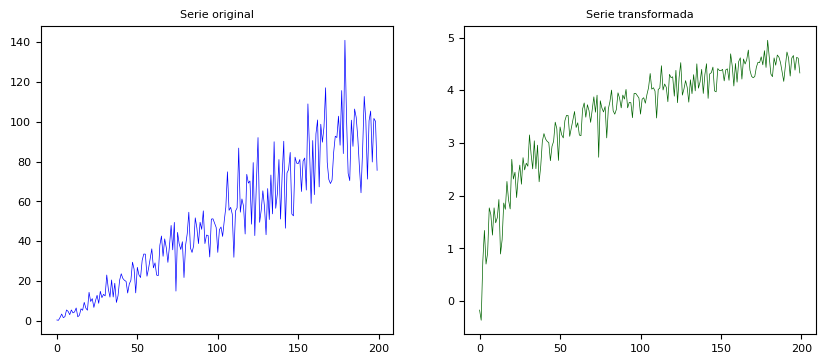

In [9]:
plt.figure(figsize=(10, 4))

# Visualización de la serie original
plt.subplot(121)
plt.plot(series, color='blue', linewidth=0.5)
plt.title('Serie original', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Visualización de la serie transformada
plt.subplot(122)
plt.plot(log_transformed_series, color='darkgreen', linewidth=0.5)
plt.title('Serie transformada', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

Una vez aplicada la transformación, vemos que no tenemos una varianza creciente. Ahora es constante. Es cierto que la tendencia no es del todo lineal con esta transformación ya que presenta una ligera curva logaritmica, pero quizá diferenciando se consiga eliminar esa curvatura y ya de paso la tendencia. Vamos en primer lugar a visualizar las ACFs pero esta vez con la serie transformada.

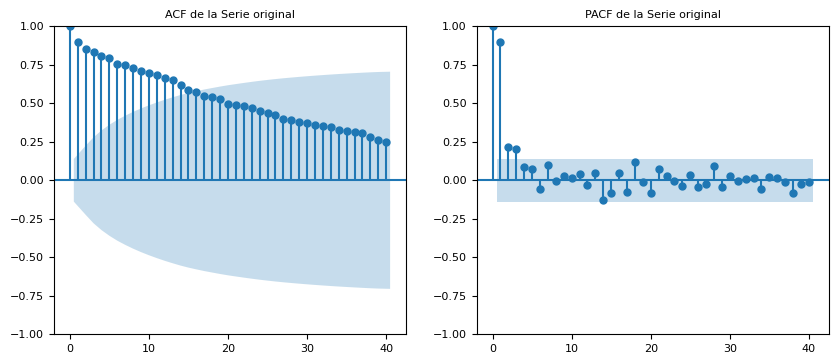

In [16]:
# ACF y PACF de la serie original
plt.figure(figsize=(10, 4))

# ACF con intervalo de confianza
plt.subplot(121)
plot_acf(log_transformed_series, lags=40, alpha=0.05, ax=plt.gca())
plt.title('ACF de la Serie transformada', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# PACF con intervalo de confianza
plt.subplot(122)
plot_pacf(log_transformed_series, lags=40, alpha=0.05, ax=plt.gca())
plt.title('PACF de la Serie transformada', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

Se puede ver en la PACF que se mantiene la idea de utilizar 3 retardos para modelar la parte autoregresiva, pero en la parte de medias móviles aún no podemos determinar el orden puesto que la tendencia creciente nos hace inviable encontrar el orden. Vamos a proceder a diferenciar la serie a ver si eliminamos la tendencia y volvemos a comprobar el orden de medias móviles.

In [17]:
# Realizar una diferenciación para eliminar la tendencia residual
log_diff_series = log_transformed_series.diff().dropna()

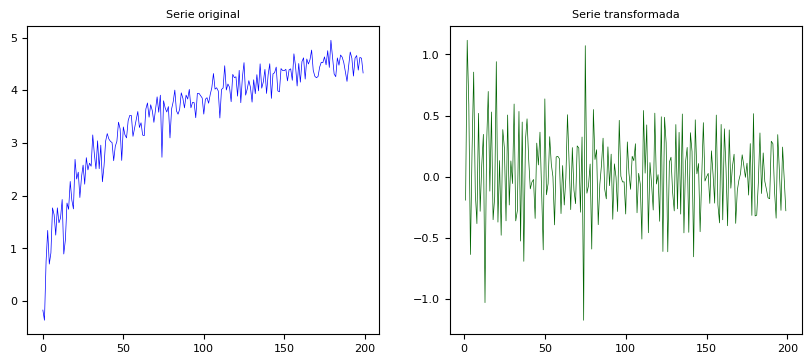

In [18]:
plt.figure(figsize=(10, 4))

# Visualización de la serie original
plt.subplot(121)
plt.plot(log_transformed_series, color='blue', linewidth=0.5)
plt.title('Serie original', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Visualización de la serie transformada
plt.subplot(122)
plt.plot(log_diff_series, color='darkgreen', linewidth=0.5)
plt.title('Serie transformada', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

Ahora si que se ve que la serie transformada diferenciada una vez, consigue eliminar la tendencia y se ve más claro también la desaparición de la varianza creciente. Vamos ahora a ver de nuevo las ACFs.

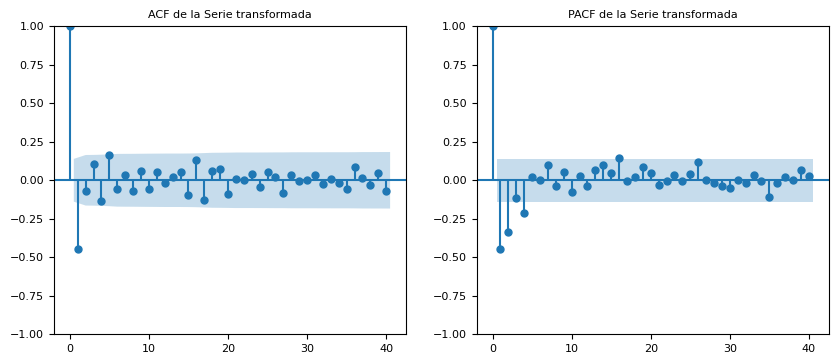

In [20]:
# ACF y PACF de la serie original
plt.figure(figsize=(10, 4))

# ACF con intervalo de confianza
plt.subplot(121)
plot_acf(log_diff_series, lags=40, alpha=0.05, ax=plt.gca())
plt.title('ACF de la Serie transformada', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# PACF con intervalo de confianza
plt.subplot(122)
plot_pacf(log_diff_series, lags=40, alpha=0.05, ax=plt.gca())
plt.title('PACF de la Serie transformada', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

Ahora la PACF más o menos muestra 3 retardos, quizá 4 en esta ocasión. Al haber aparecido un nuevo retardo significativo, podemos incluirlo en el modelo ARIMA para la parte autorregresiva. En cambio ahora tenemos algo diferente en la parte de medias móviles en el lado de la ACF. En ella podemos apreciar un retardo significativo. Por tanto escogemos un orden 1 para las medias móviles.

Pasamos a entrenar el modelo ARIMA. La diferenciación no la incluimos en los datos que le pasamos al modelo, en su lugar, le decimos al modelo que el orden de la parte integrada sea 1, para que así el modelo lleve a cabo la diferenciación por nosotros y luego la deshaga también al devolvernos los valores predichos por el modelo. Por tanto, creamos un modelo ARIMA(4,1,1)

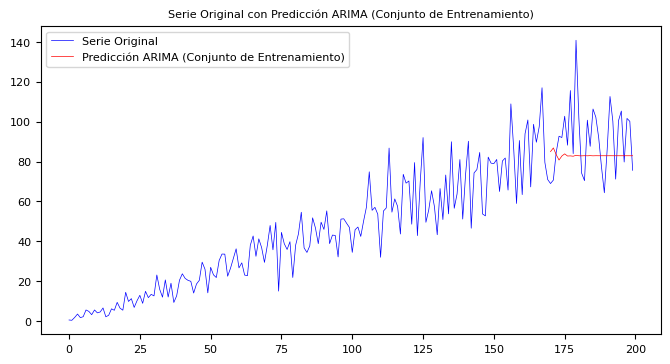

Coeficientes del modelo ARIMA:
AR: [-1.34548955 -0.93067926 -0.52715721 -0.25141284]
MA: [0.72833746]
Constante: -1.3454895462858638


C:\Users\Carlos\AppData\Local\Temp\ipykernel_10708\2741537124.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Constante: {model_fit.params[0]}")


In [25]:
# Dividir la serie en conjunto de entrenamiento y conjunto de test
train = log_transformed_series[:-30]
test = log_transformed_series[-30:]

# Ajuste del modelo ARIMA (4, 1, 1) como ejemplo
model = ARIMA(train, order=(4, 1, 1))
model_fit = model.fit()

# Predicción de la serie transformada
forecast_transf = model_fit.forecast(steps=30)

# Deshacer el logaritmo
forecast_original = np.exp(forecast_transf) - abs(series.min()) - 1e-6

# Predicciones para el conjunto de entrenamiento (no solo para los valores futuros)
#train_forecast = model_fit.predict(start=1, end=n, typ='levels')

# Graficar la serie original con las predicciones en el conjunto de entrenamiento
plt.figure(figsize=(8, 4))
plt.plot(series, label='Serie Original', color='blue', linewidth=0.5)
plt.plot(forecast_original, label='Predicción ARIMA (Conjunto de Entrenamiento)', color='red', linewidth=0.5)
plt.title('Serie Original con Predicción ARIMA (Conjunto de Entrenamiento)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.show()

# Imprimir los coeficientes del modelo ARIMA ajustado
print(f"Coeficientes del modelo ARIMA:")
print(f"AR: {model_fit.arparams}")
print(f"MA: {model_fit.maparams}")
print(f"Constante: {model_fit.params[0]}")

La conclusión al ver la predicción que hace este modelo es que no es muy bueno para predecir esta serie. La razón detras de ello es que la serie es prácticamente solo ruido. El ruido es un tipo de serie aleatoria muy dificil de modelar por no decir imposible. No hay relación entre los distitnos valores y retardos. Por esta razón no se puede modelar.

Si tuvieramos algún tipo de patrón en los datos más allá del ruido pero siendo una serie estacionaria, los retardos que nos mostrarían las ACF y PACF ayudarían de verdad a determinar el orden del modelo ARIMA y por la misma, podríamos modelar bien la serie.